In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-15 21:34:15.911580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744742055.942736  194562 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744742055.948214  194562 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744742055.961715  194562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744742055.961733  194562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744742055.961734  194562 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
precision_60000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/30000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/30000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        precision_60000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(precision_60000).transpose().to_dict()
    print(x)
    with open('results_60000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_60000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_60000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_60000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
397888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
397889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
397890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
397891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
397892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
397888    Bruteforce
397889    Bruteforce
397890    Bruteforce
397891    Bruteforce
397892    Bruteforce
Name: Attack Type, Length: 397893, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338209, 46), (338209,), (59684, 46), (59684,))

# K Nearest Neighbour

In [16]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 1min 41s, sys: 40.6 ms, total: 1min 41s
Wall time: 25.7 s


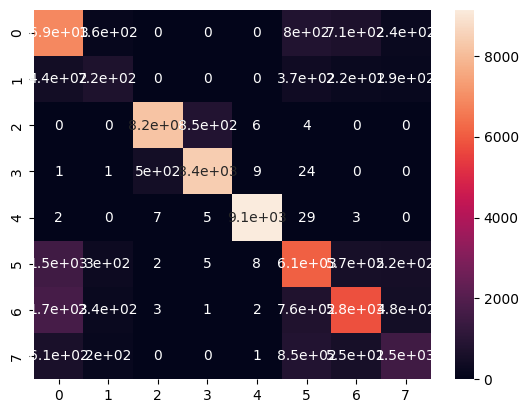

In [17]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [18]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [19]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [20]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [21]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.783878,0.784465,0.781652,0.783878,0.748748,0.780594,3.90056,1.974983,25.677149


{'precision': {'Benign': 0.7824553419046535, 'Bruteforce': 0.3693181818181818, 'DDoS': 0.9053711260615419, 'DoS': 0.9403685092127303, 'Mirai': 0.9949923797082517, 'Recon': 0.6744855056428414, 'Spoofing': 0.6459821428571428, 'Web': 0.41007194244604317}, 'recall': {'Benign': 0.6166053976508563, 'Bruteforce': 0.4421768707482993, 'DDoS': 0.9413990825688073, 'DoS': 0.9074353448275863, 'Mirai': 0.9971634300676413, 'Recon': 0.6816504528681651, 'Spoofing': 0.7378888322284549, 'Web': 0.5197568389057751}, 'f1-score': {'Benign': 0.6897001303780965, 'Bruteforce': 0.4024767801857585, 'DDoS': 0.9230336762804295, 'DoS': 0.9236084452975047, 'Mirai': 0.9960767218831735, 'Recon': 0.6780490517768756, 'Spoofing': 0.6888835991430612, 'Web': 0.4584450402144772}}


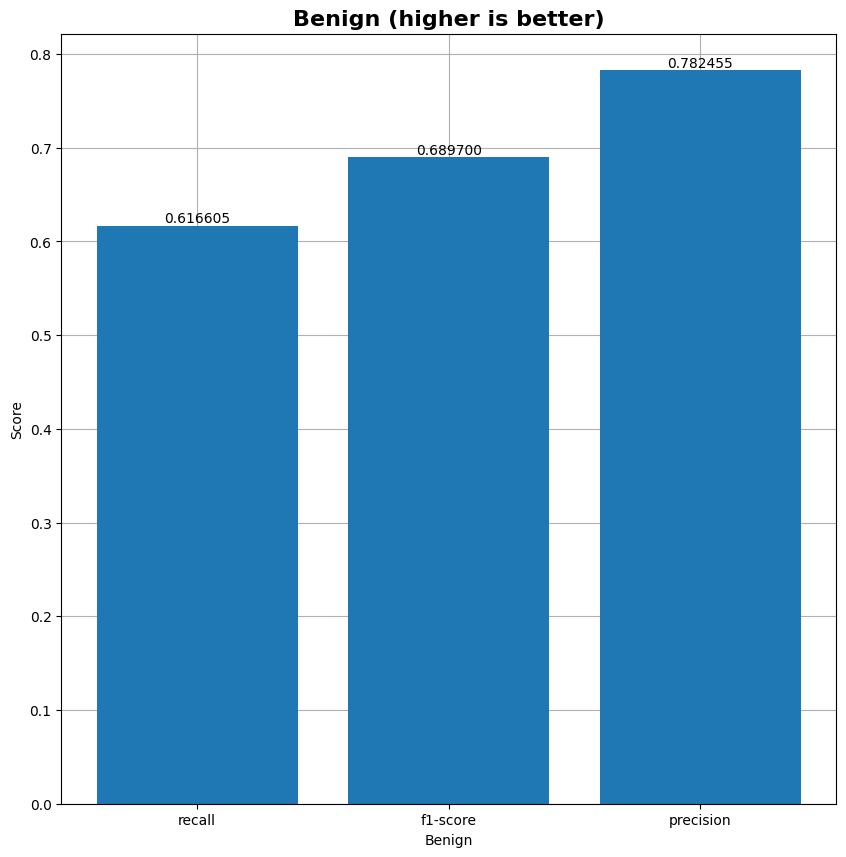

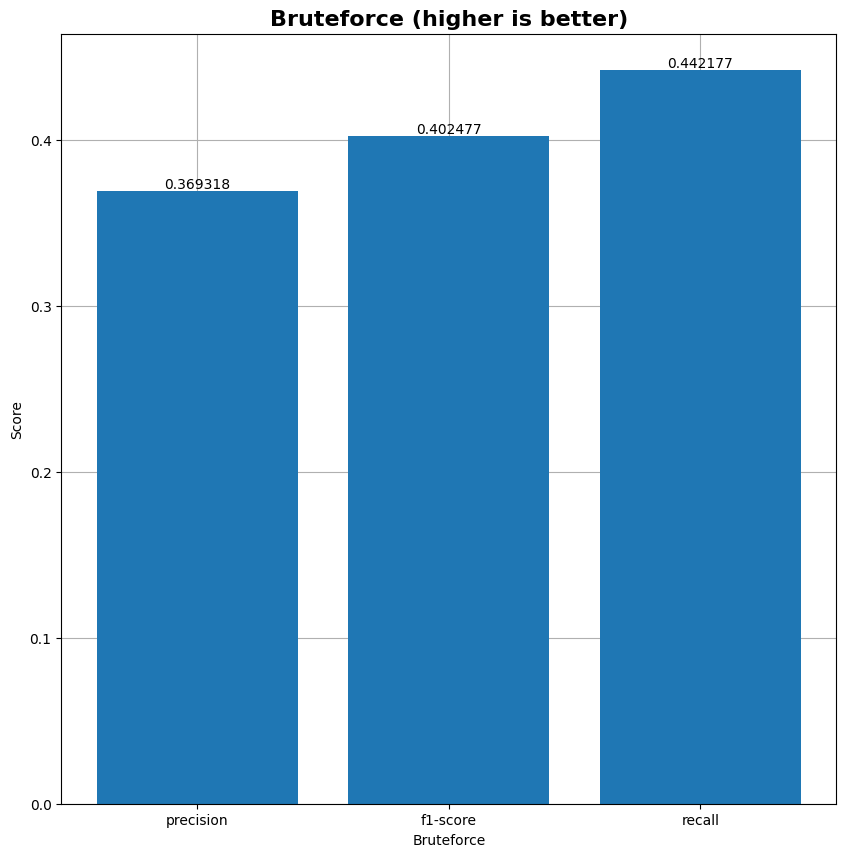

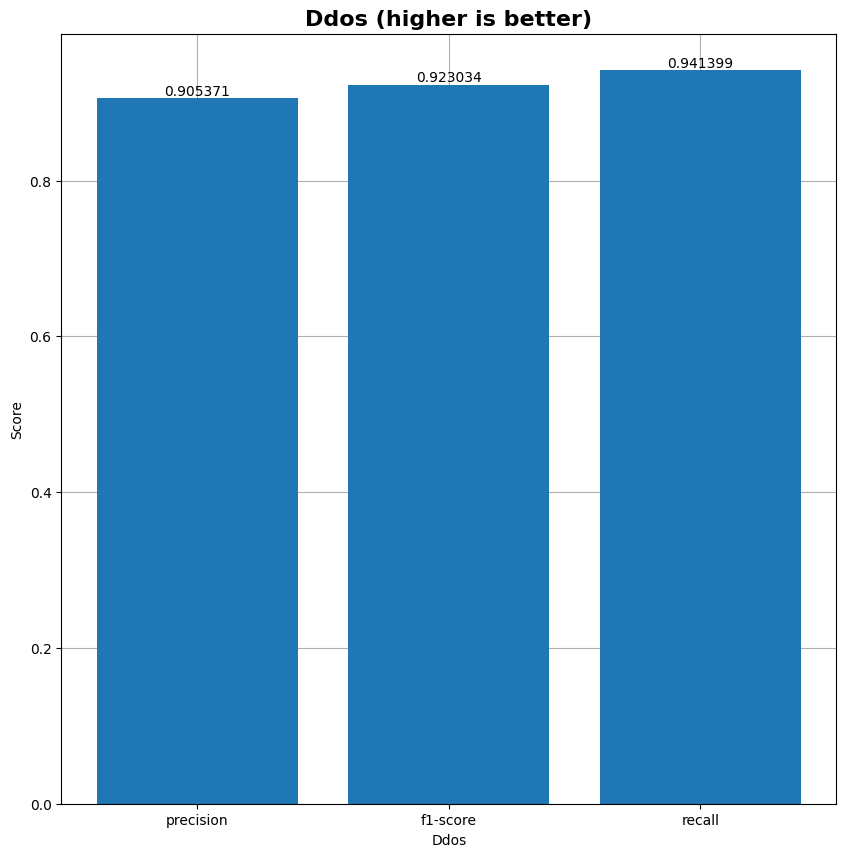

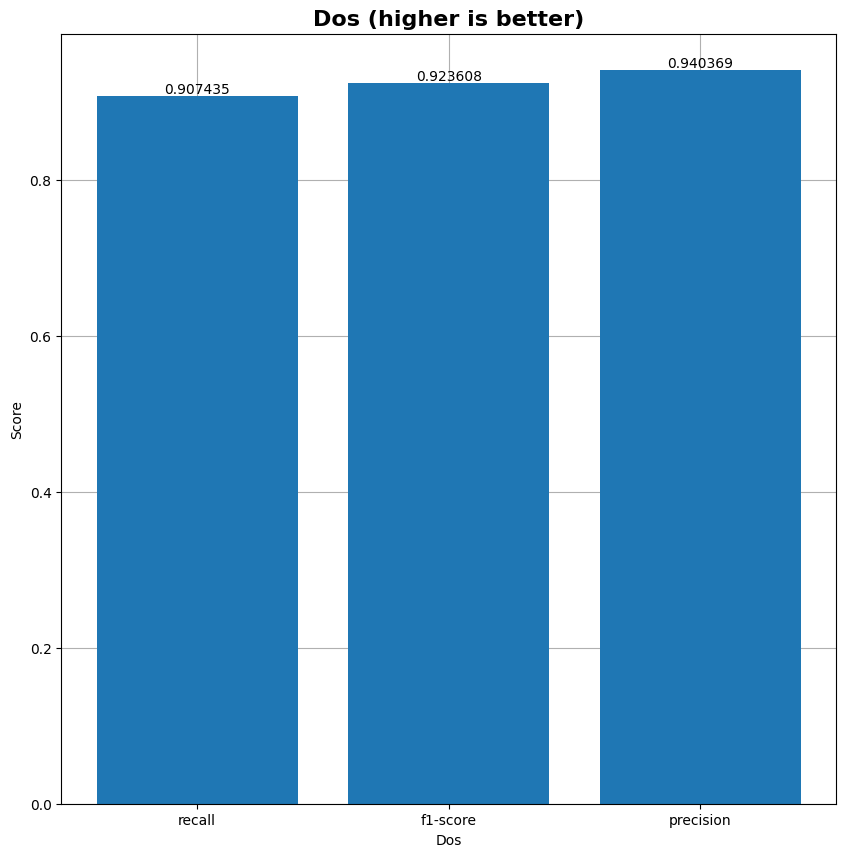

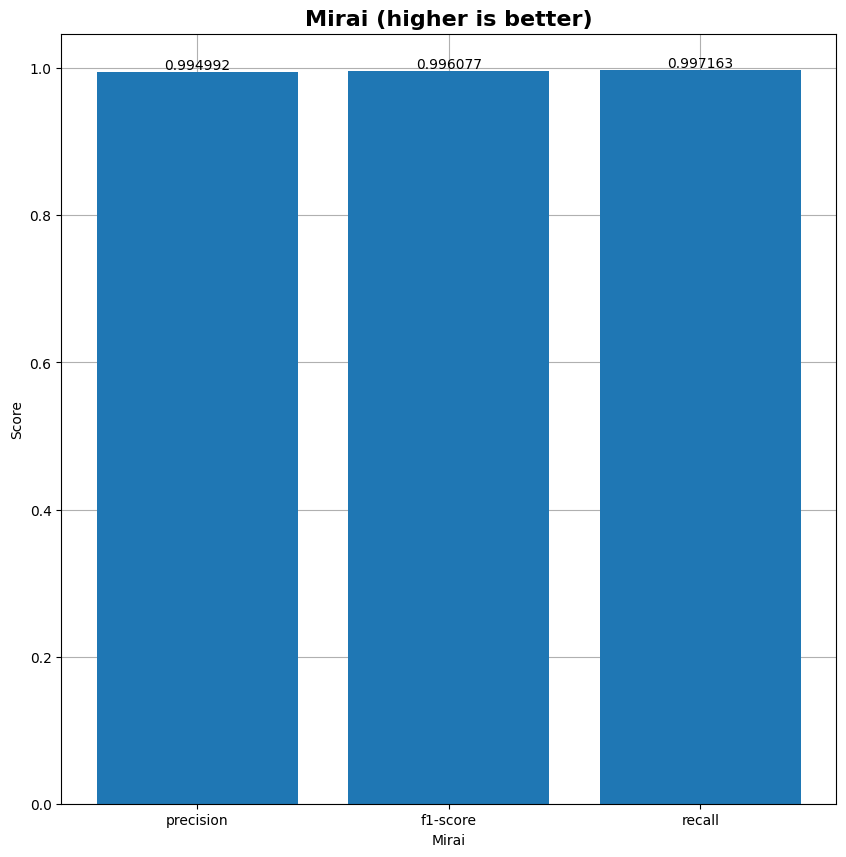

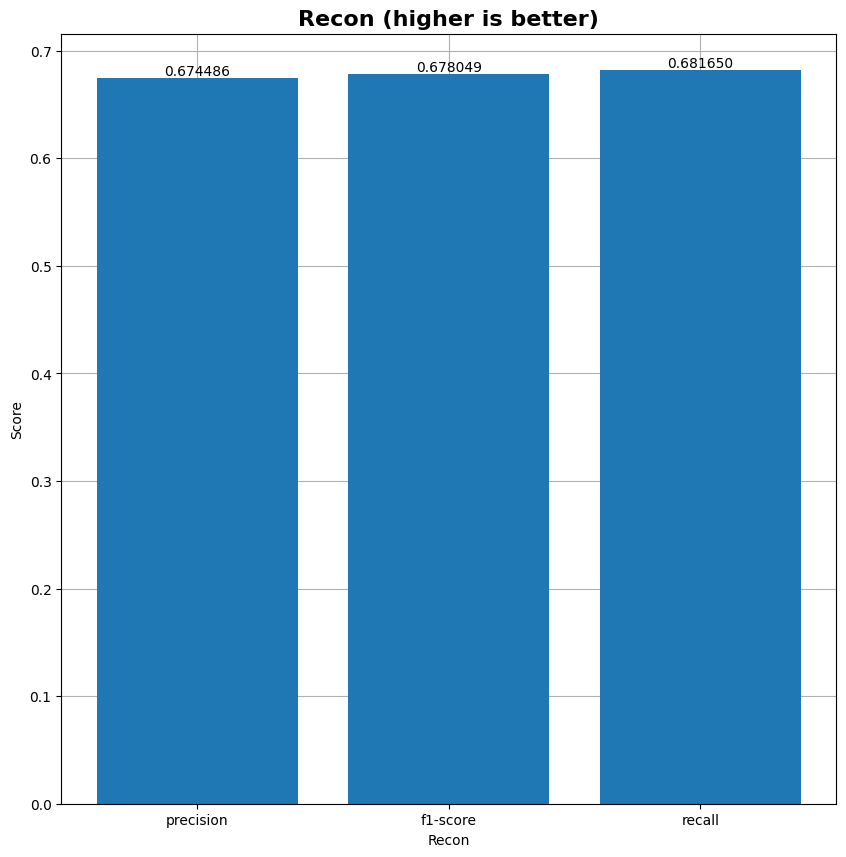

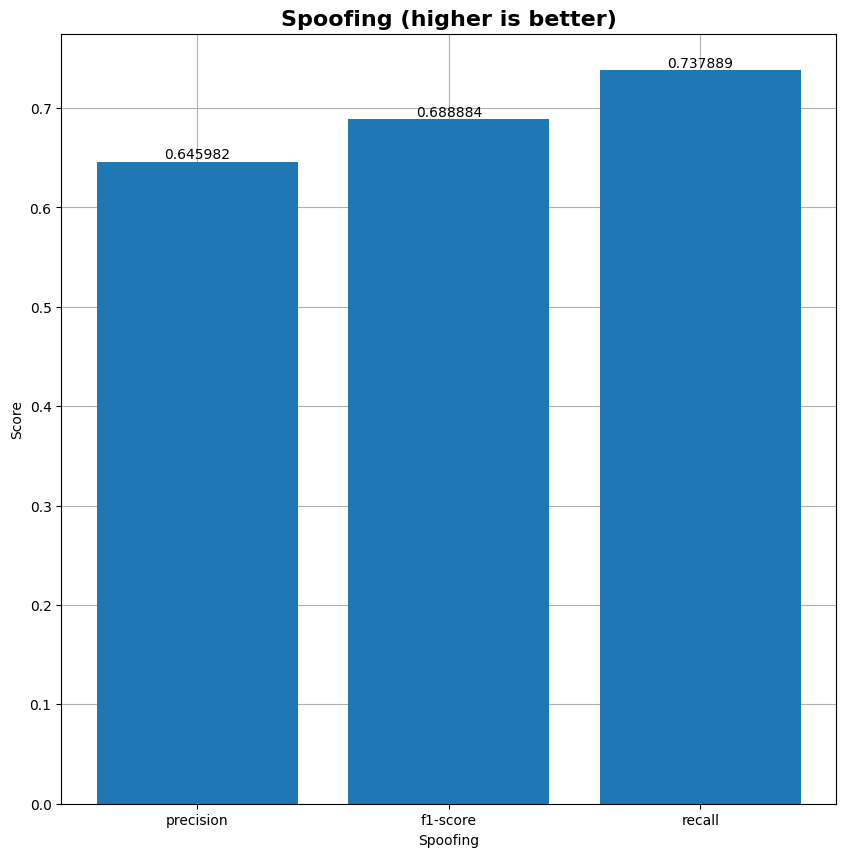

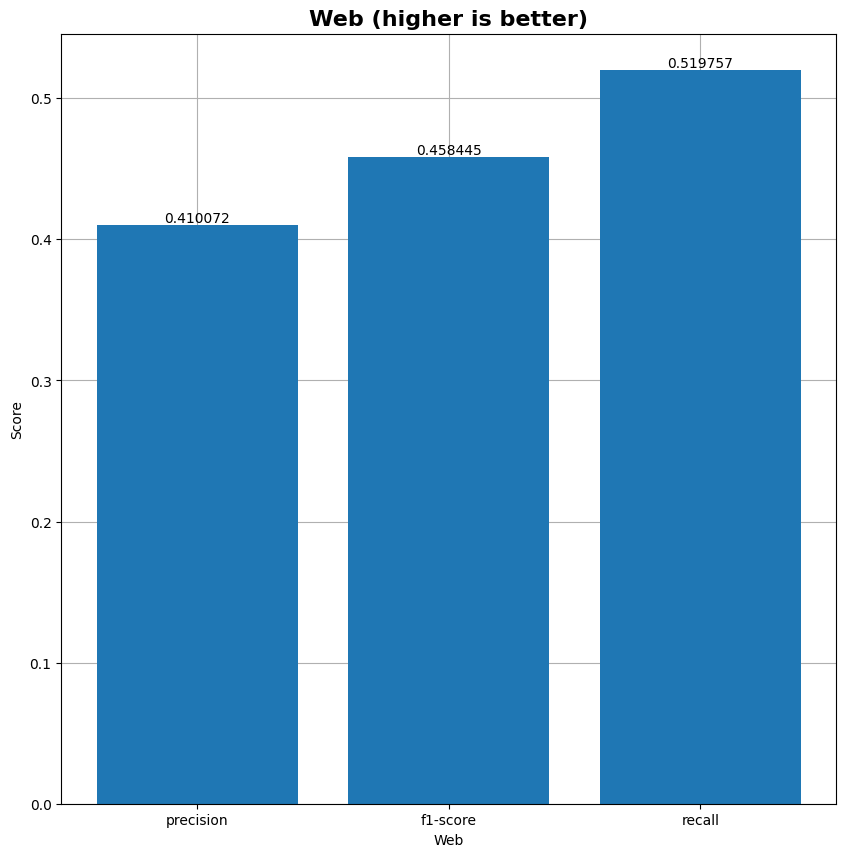

In [22]:
plot_mc(y_pred, y_test, "kNN")

In [23]:
model_name = "kNN_60000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Random Forest

In [24]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 2min 41s, sys: 682 ms, total: 2min 42s
Wall time: 21.5 s


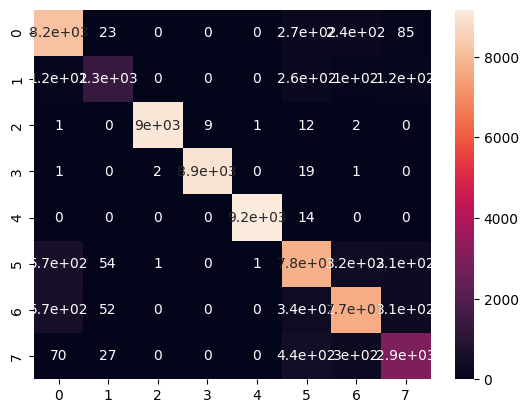

In [25]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [26]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [27]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [28]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [29]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.783878,0.784465,0.781652,0.783878,0.748748,0.780594,3.900560,1.974983,25.677149
RF,0.921855,0.922377,0.921428,0.921855,0.909012,0.270726,1.289391,1.135513,21.470258


{'precision': {'Benign': 0.9295710547275002, 'Bruteforce': 0.6875, 'DDoS': 0.9972427484283666, 'DoS': 0.9974316024567281, 'Mirai': 0.9984759416503375, 'Recon': 0.8604779818543926, 'Spoofing': 0.8574776785714285, 'Web': 0.7761790567545963}, 'recall': {'Benign': 0.8595476065228826, 'Bruteforce': 0.8950907868190988, 'DDoS': 0.9996683250414594, 'DoS': 0.9989934011855497, 'Mirai': 0.999781992587748, 'Recon': 0.8506891271056661, 'Spoofing': 0.8880027739251041, 'Web': 0.7792937399678973}, 'f1-score': {'Benign': 0.8931890237236252, 'Bruteforce': 0.7776803973122991, 'DDoS': 0.9984540636042403, 'DoS': 0.9982118909253465, 'Mirai': 0.9991285403050109, 'Recon': 0.8555555555555555, 'Spoofing': 0.8724733136497842, 'Web': 0.7777332799359231}}


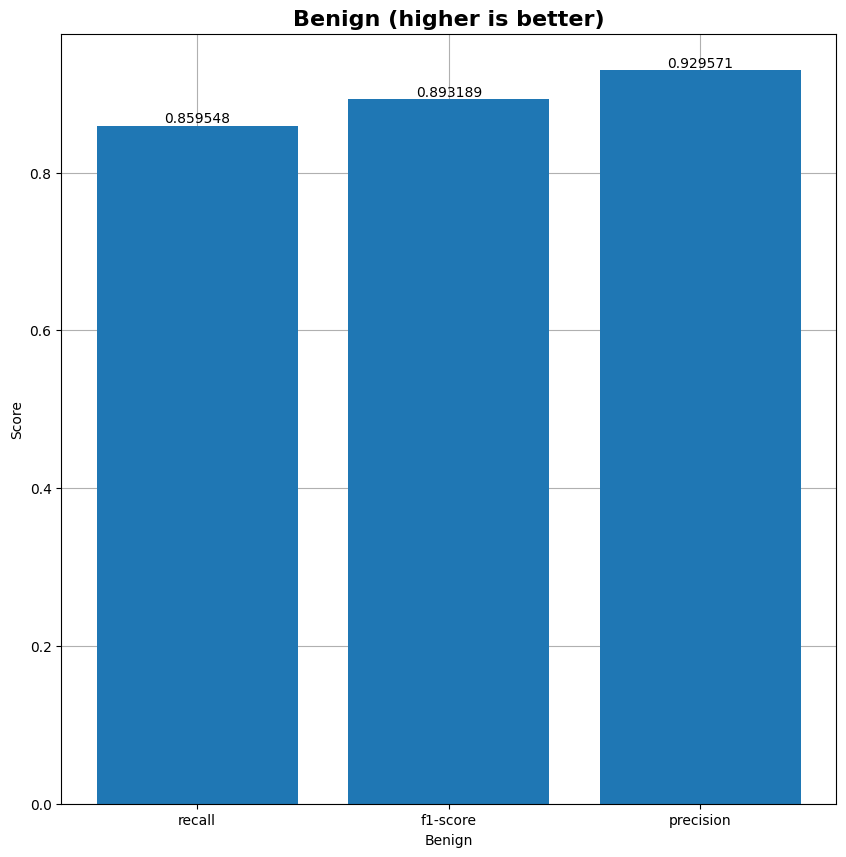

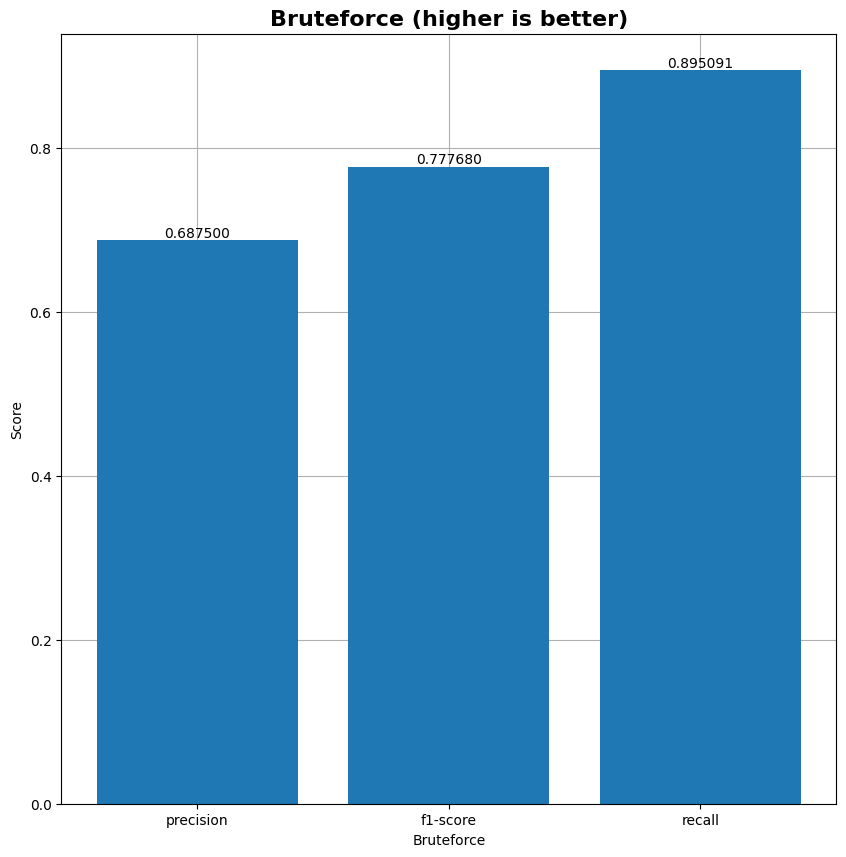

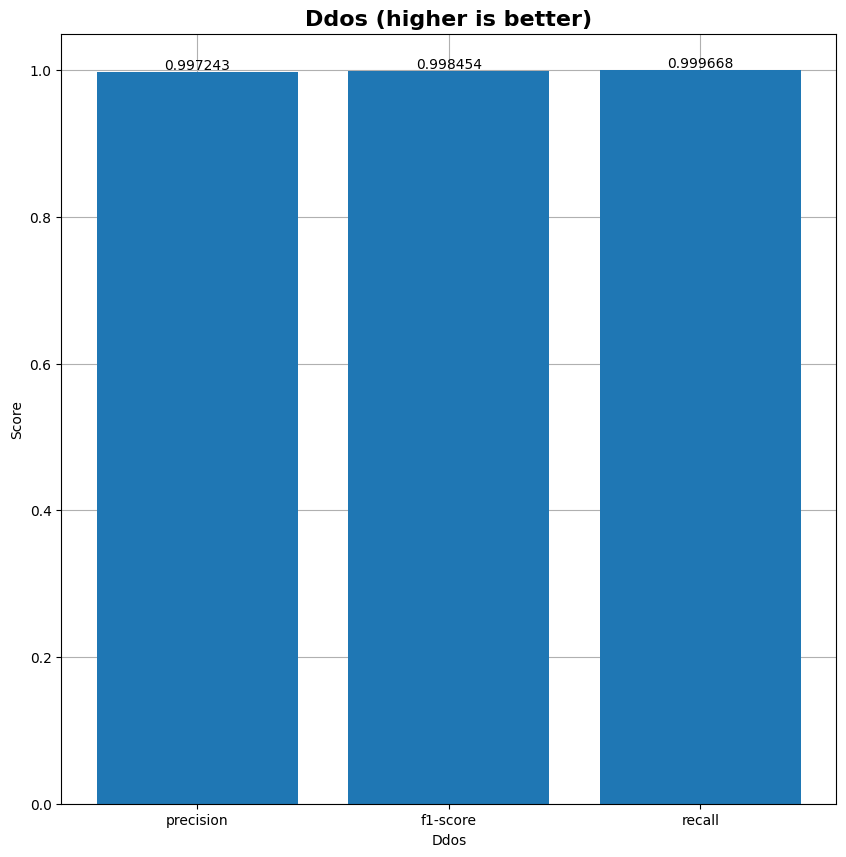

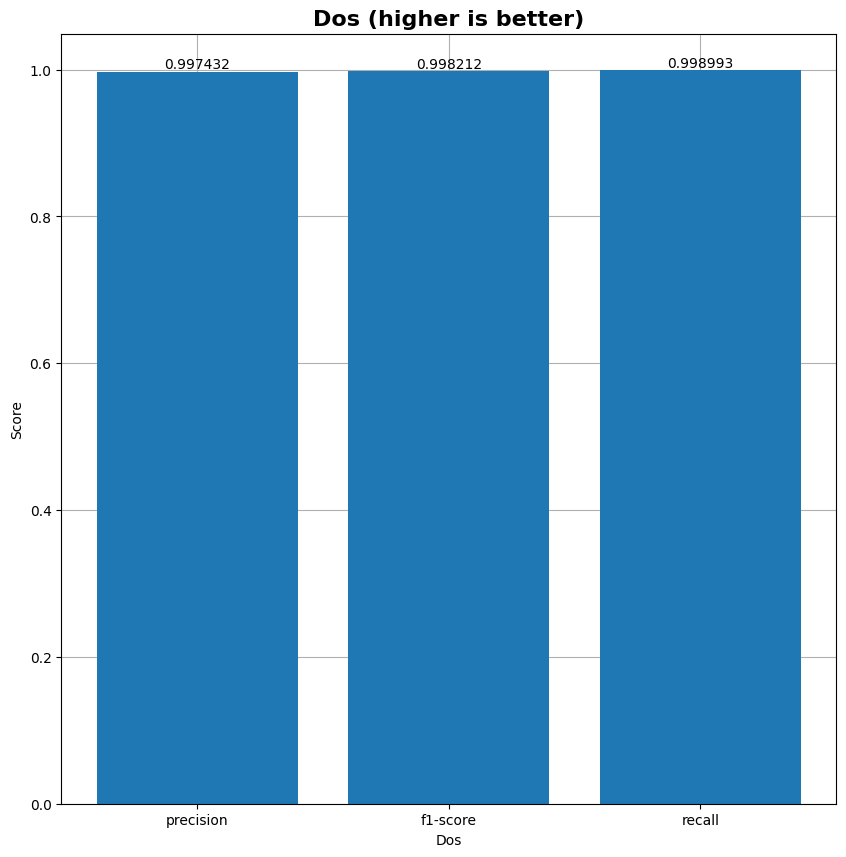

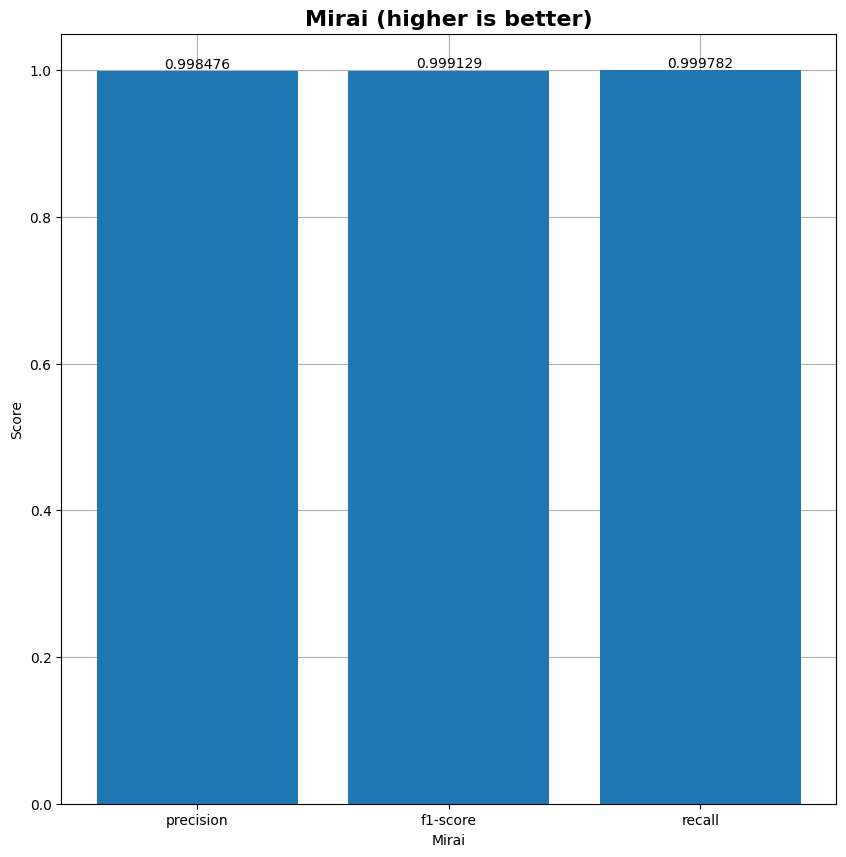

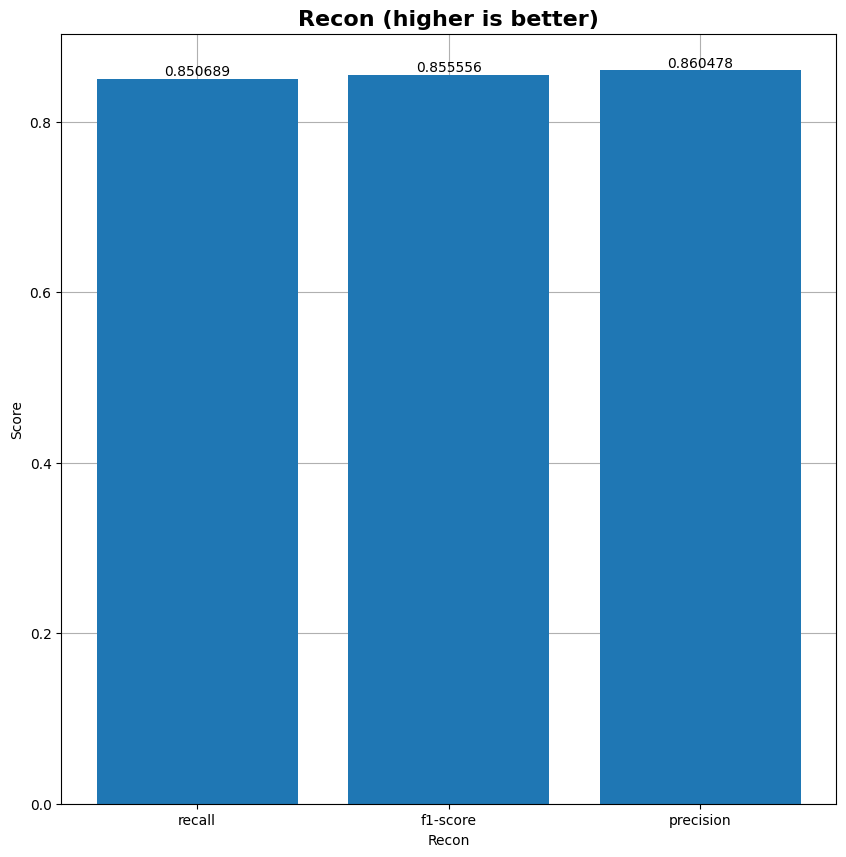

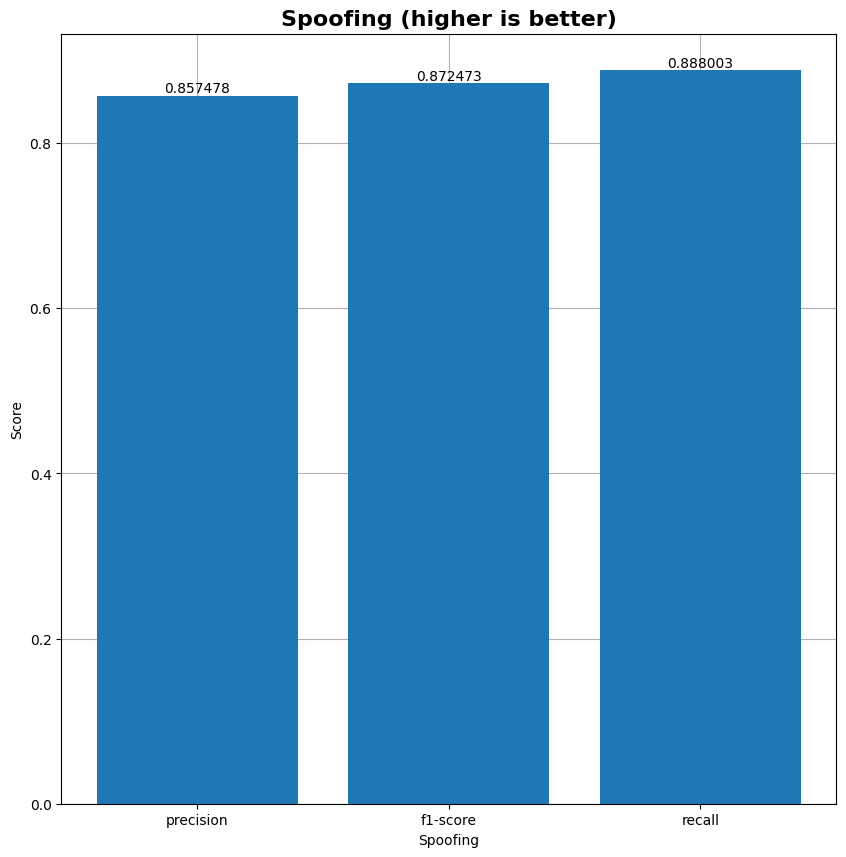

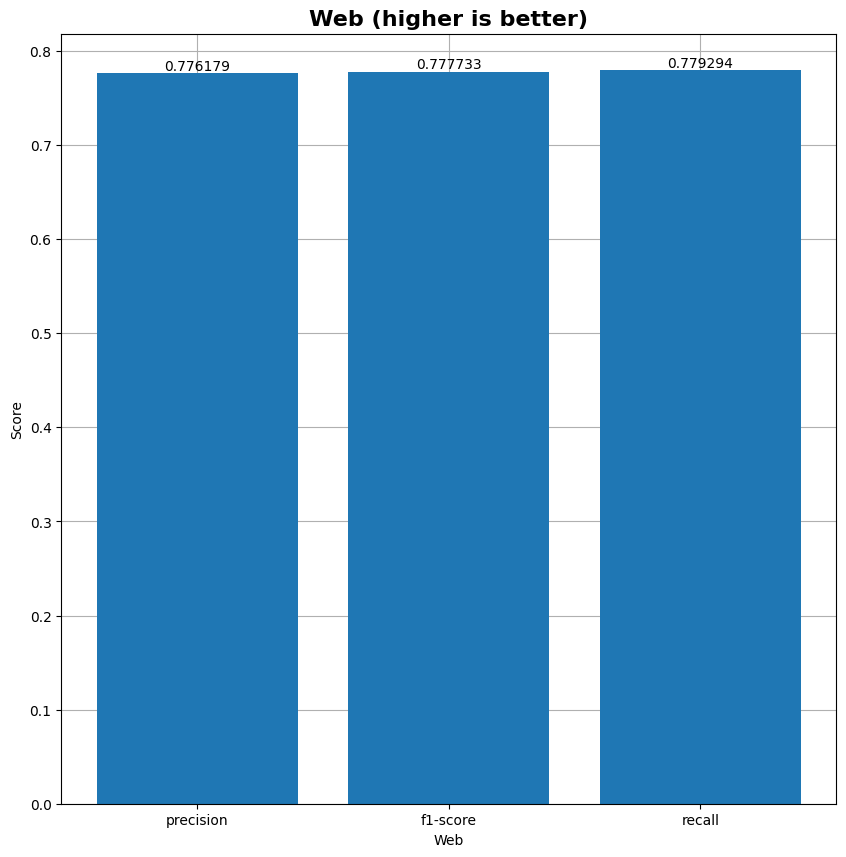

In [30]:
plot_mc(y_pred, y_test, "RF")

In [31]:
model_name = "RF_60000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [32]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 1min 37s, sys: 182 ms, total: 1min 37s
Wall time: 12.7 s


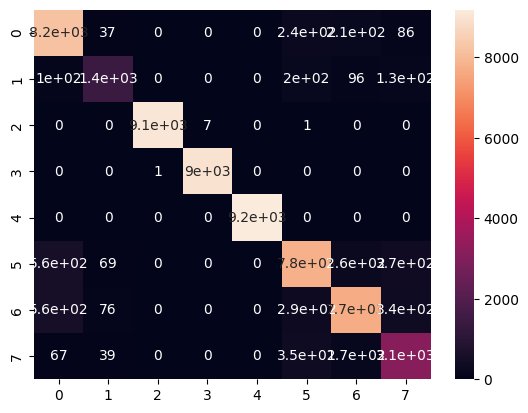

In [33]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [34]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [35]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [36]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [37]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.783878,0.784465,0.781652,0.783878,0.748748,0.780594,3.900560,1.974983,25.677149
RF,0.921855,0.922377,0.921428,0.921855,0.909012,0.270726,1.289391,1.135513,21.470258
XGBoost,0.928758,0.929692,0.928621,0.928758,0.917159,0.255613,1.236680,1.112061,12.718950


{'precision': {'Benign': 0.9343497553760383, 'Bruteforce': 0.7262396694214877, 'DDoS': 0.9991176794970773, 'DoS': 0.9998883305415969, 'Mirai': 1.0, 'Recon': 0.8619163531754813, 'Spoofing': 0.8587053571428571, 'Web': 0.8342659205968559}, 'recall': {'Benign': 0.8646941139307149, 'Bruteforce': 0.8641671788567916, 'DDoS': 0.9998896247240618, 'DoS': 0.99921883718335, 'Mirai': 1.0, 'Recon': 0.8777464788732394, 'Spoofing': 0.9132344213649851, 'Web': 0.7725141870219591}, 'f1-score': {'Benign': 0.8981734660395931, 'Bruteforce': 0.7892225652539995, 'DDoS': 0.9995035030617311, 'DoS': 0.9995534717570886, 'Mirai': 1.0, 'Recon': 0.869759392619885, 'Spoofing': 0.885130859936727, 'Web': 0.8022034332564694}}


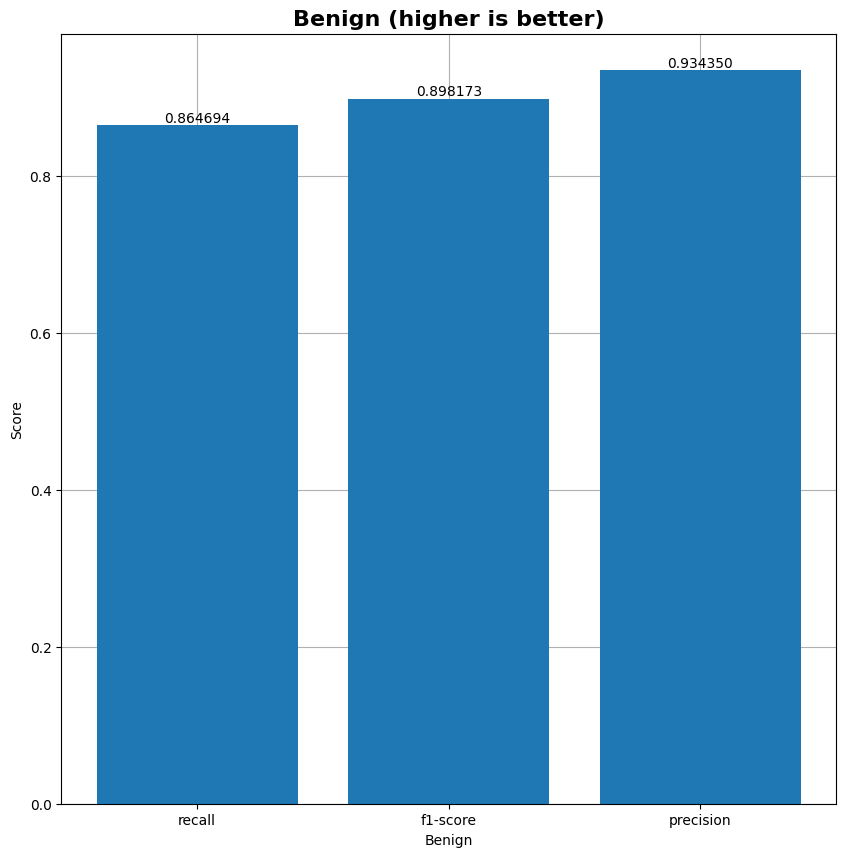

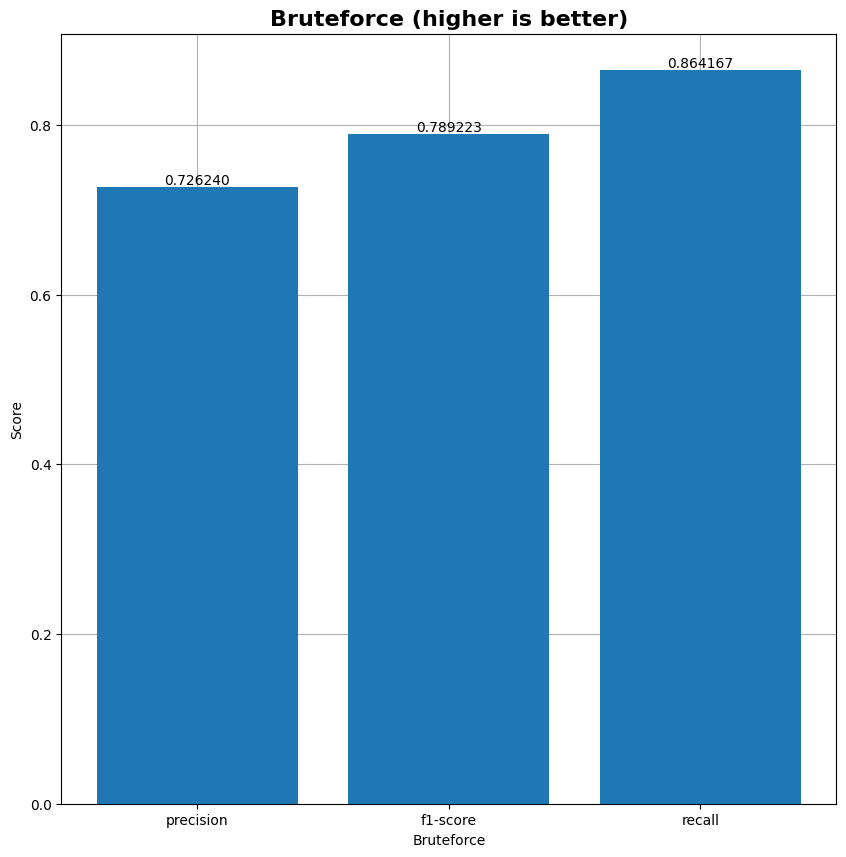

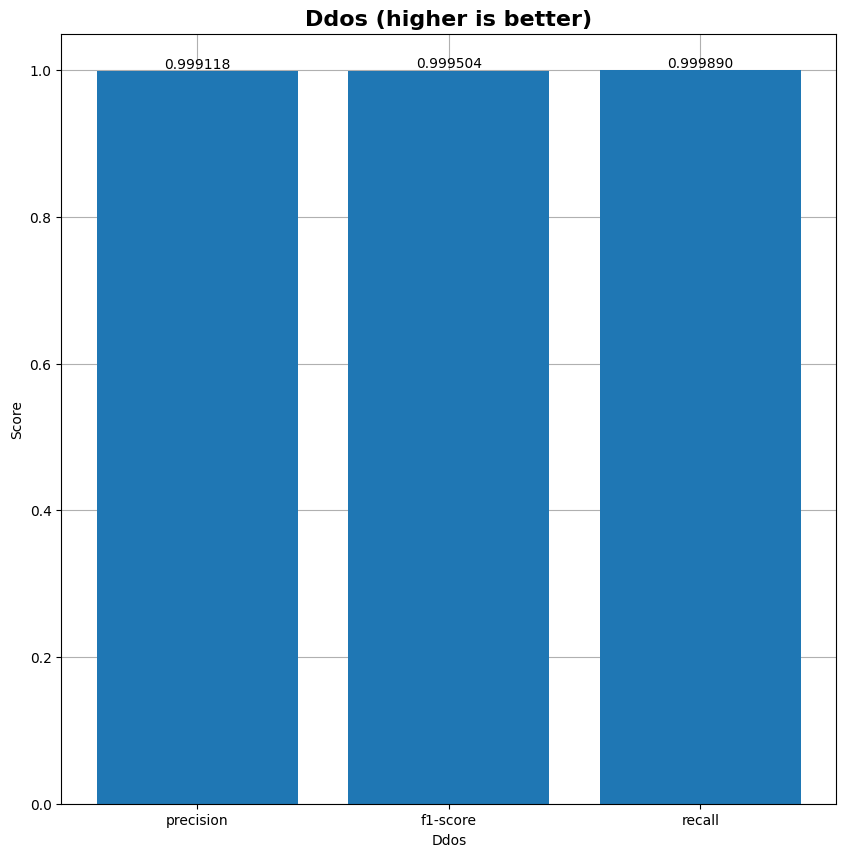

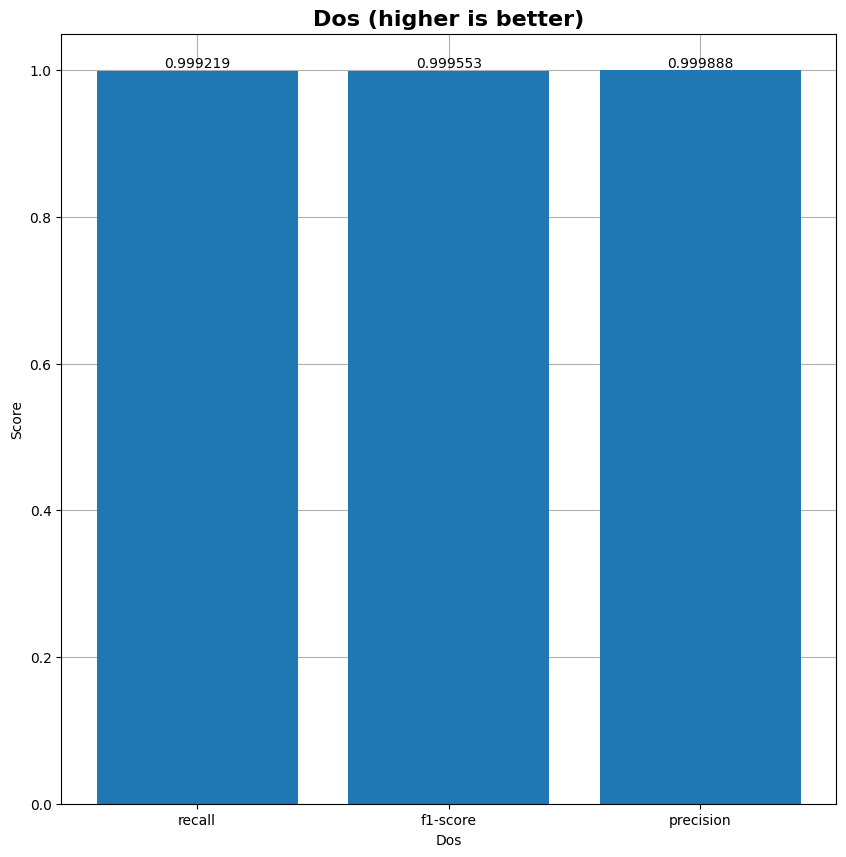

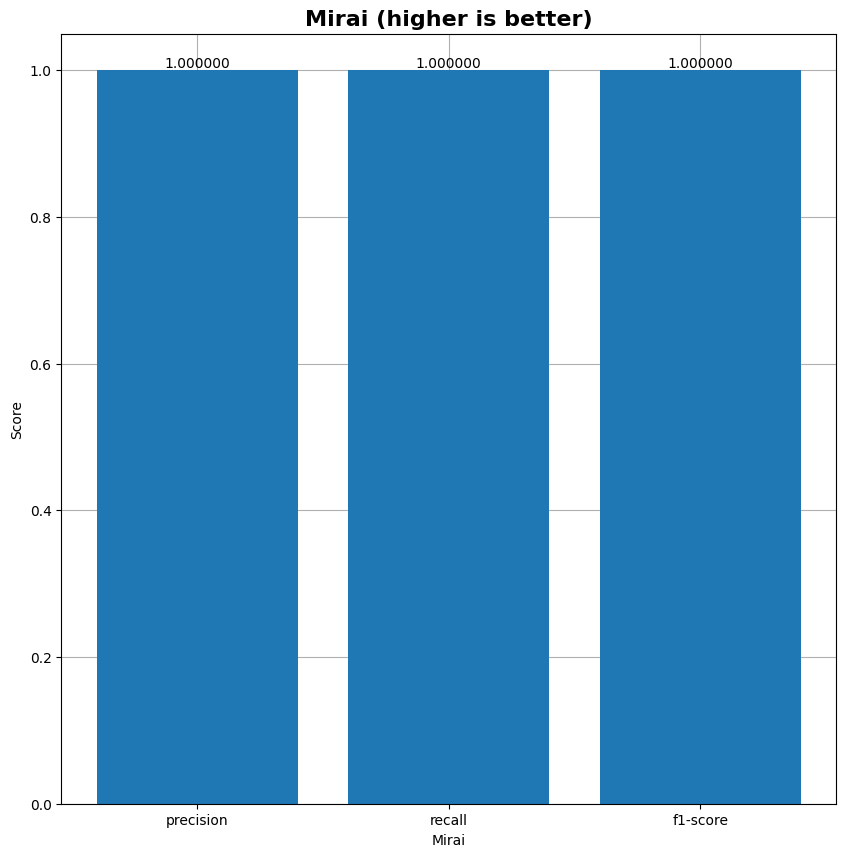

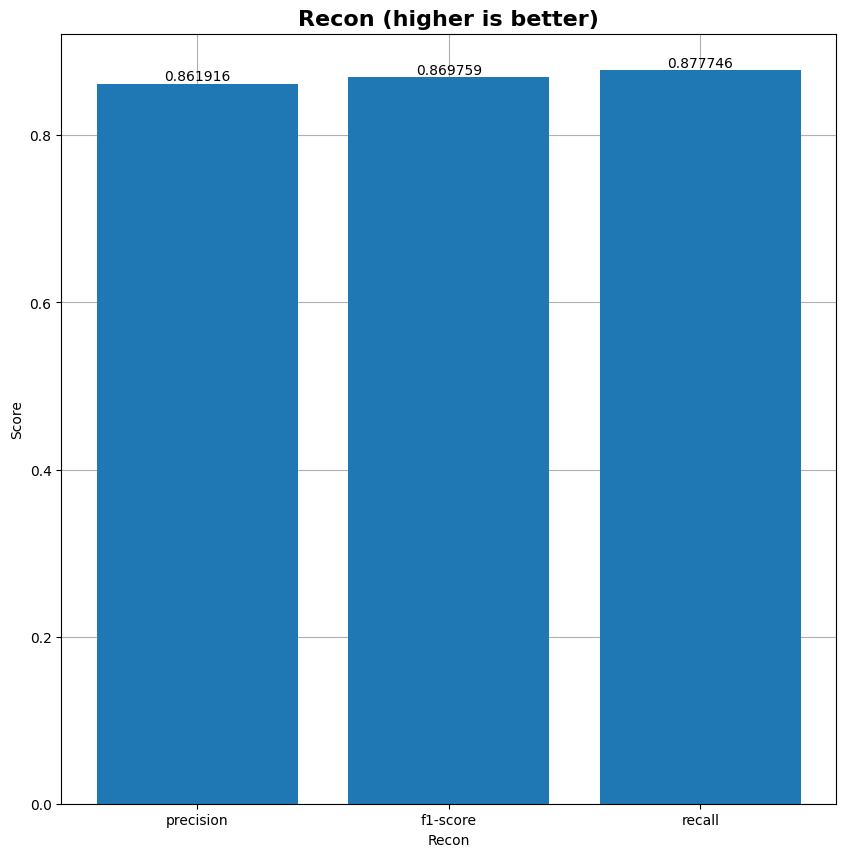

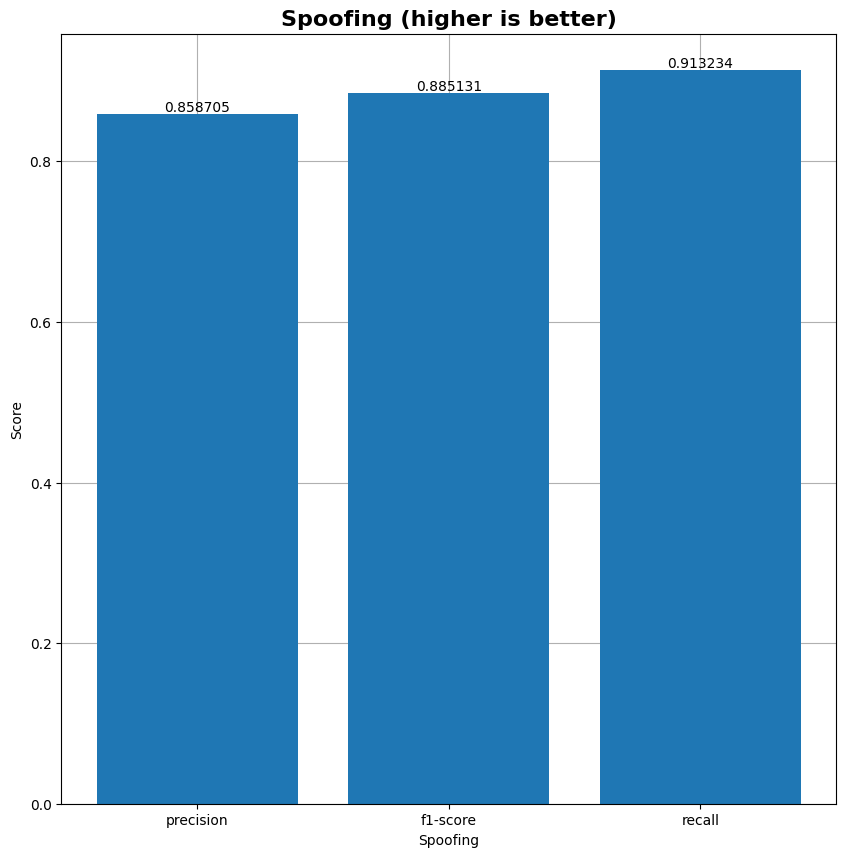

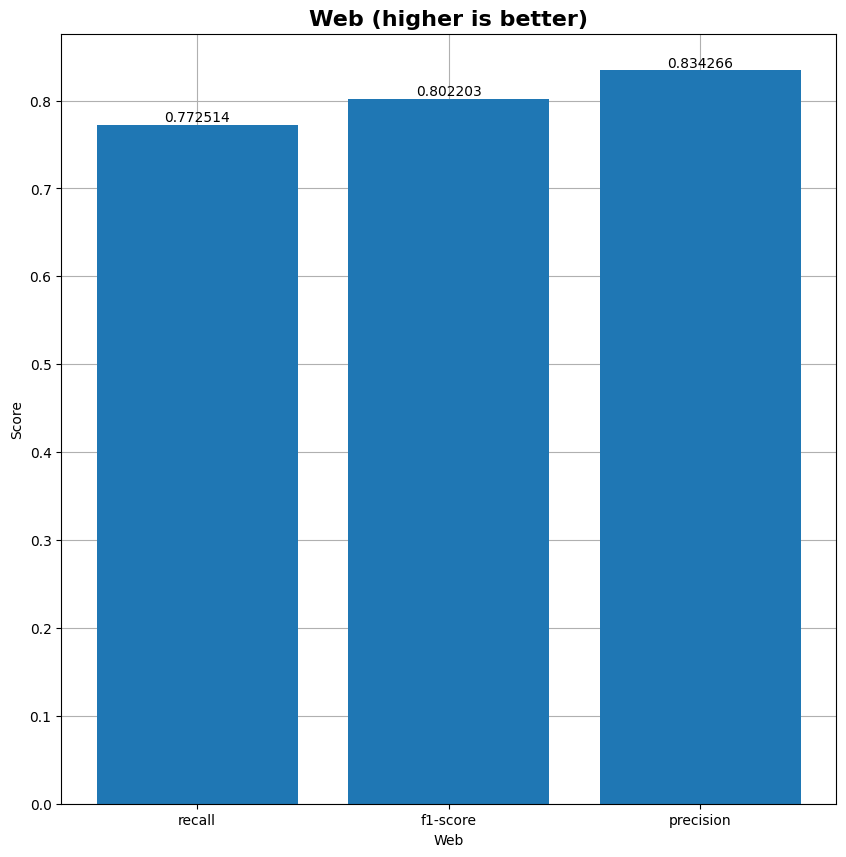

In [38]:
plot_mc(y_pred, y_test, "XGBoost")

In [39]:
model_name = "XGB_60000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [40]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5374
[LightGBM] [Info] Number of data points in the train set: 338209, number of used features: 39
[LightGBM] [Info] Start training from score -1.887710
[LightGBM] [Info] Start training from score -3.414200
[LightGBM] [Info] Start training from score -1.893153
[LightGBM] [Info] Start training from score -1.890956
[LightGBM] [Info] Start training from score -1.895492
[LightGBM] [Info] Start training from score -1.892584
[LightGBM] [Info] Start training from score -1.891054
[LightGBM] [Info] Start training from score -2.775529


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 39.2 s, sys: 143 ms, total: 39.3 s
Wall time: 10 s


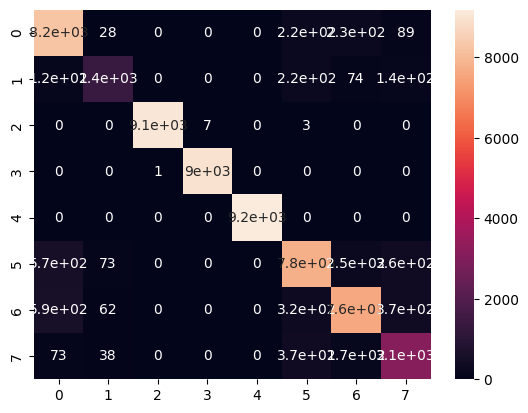

In [41]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [42]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [43]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [44]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [45]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.783878,0.784465,0.781652,0.783878,0.748748,0.780594,3.900560,1.974983,25.677149
RF,0.921855,0.922377,0.921428,0.921855,0.909012,0.270726,1.289391,1.135513,21.470258
XGBoost,0.928758,0.929692,0.928621,0.928758,0.917159,0.255613,1.236680,1.112061,12.718950
LightGBM,0.926647,0.927809,0.926481,0.926647,0.914725,0.262231,1.270173,1.127019,10.012398


{'precision': {'Benign': 0.9354875412447378, 'Bruteforce': 0.7138429752066116, 'DDoS': 0.9988970993713466, 'DoS': 0.9998883305415969, 'Mirai': 1.0, 'Recon': 0.8605886258021687, 'Spoofing': 0.8512276785714286, 'Web': 0.826005861977085}, 'recall': {'Benign': 0.8588739162227097, 'Bruteforce': 0.8730259001895135, 'DDoS': 0.9998896003532789, 'DoS': 0.99921883718335, 'Mirai': 1.0, 'Recon': 0.872462142456534, 'Spoofing': 0.9134131736526946, 'Web': 0.7639231148348941}, 'f1-score': {'Benign': 0.8955451475874088, 'Bruteforce': 0.7854504120488776, 'DDoS': 0.9993931034482758, 'DoS': 0.9995534717570886, 'Mirai': 1.0, 'Recon': 0.8664847100763103, 'Spoofing': 0.8812247255921433, 'Web': 0.7937524004608885}}


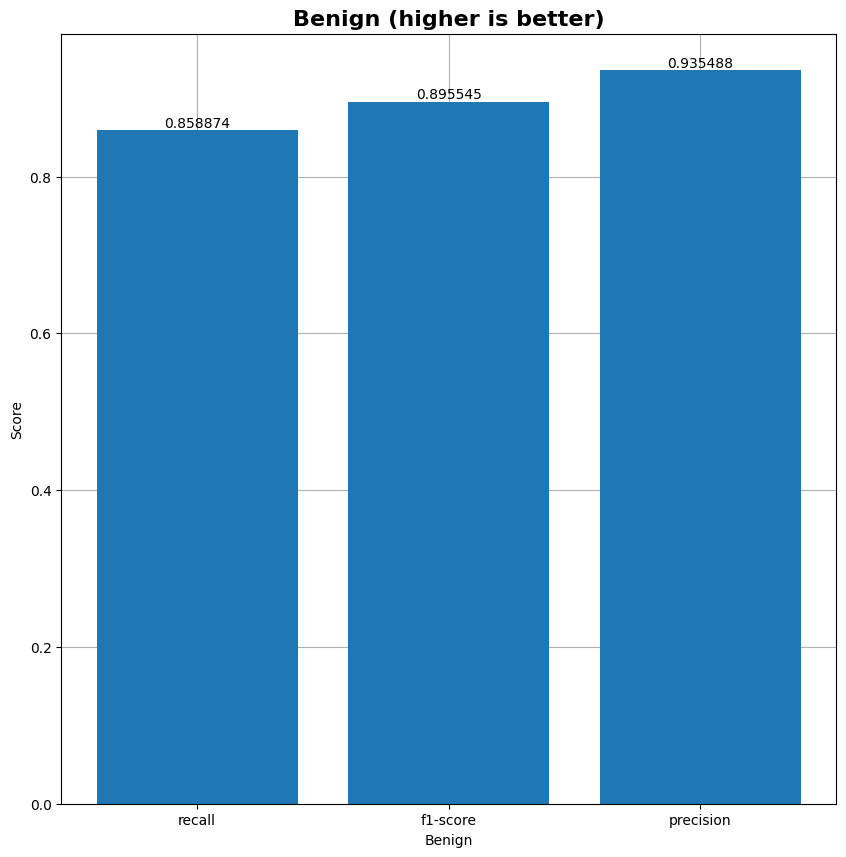

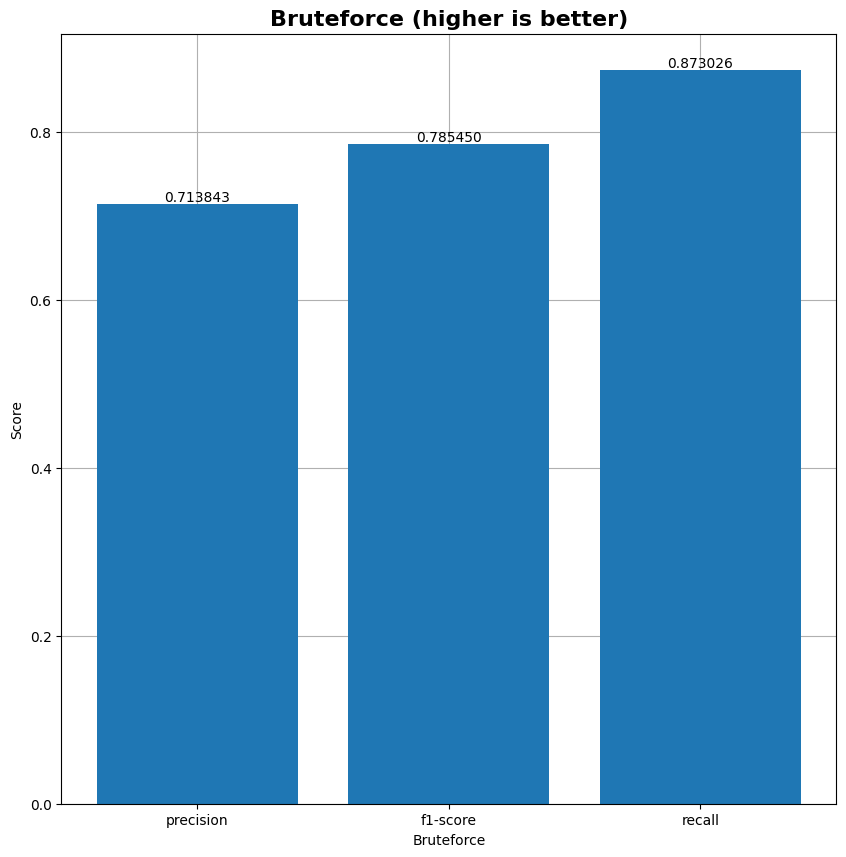

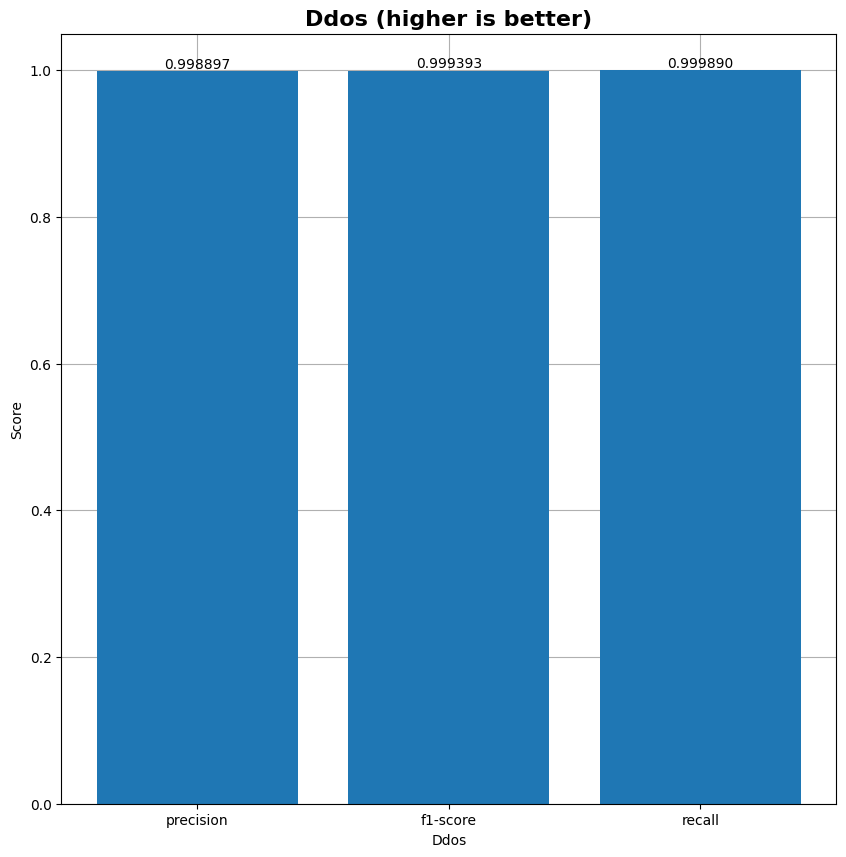

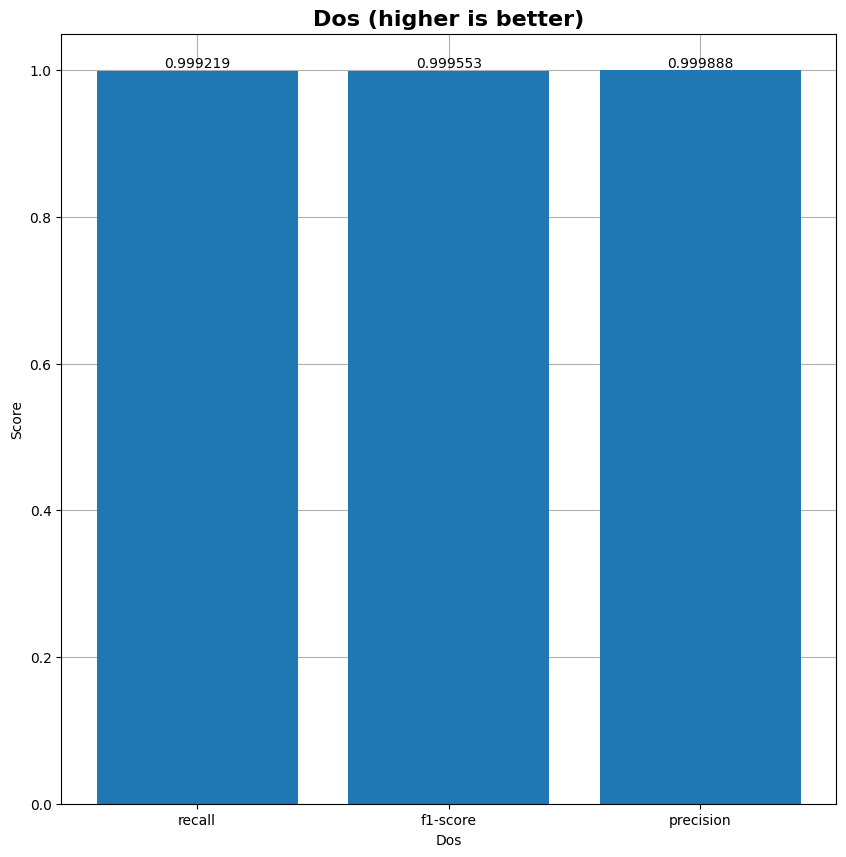

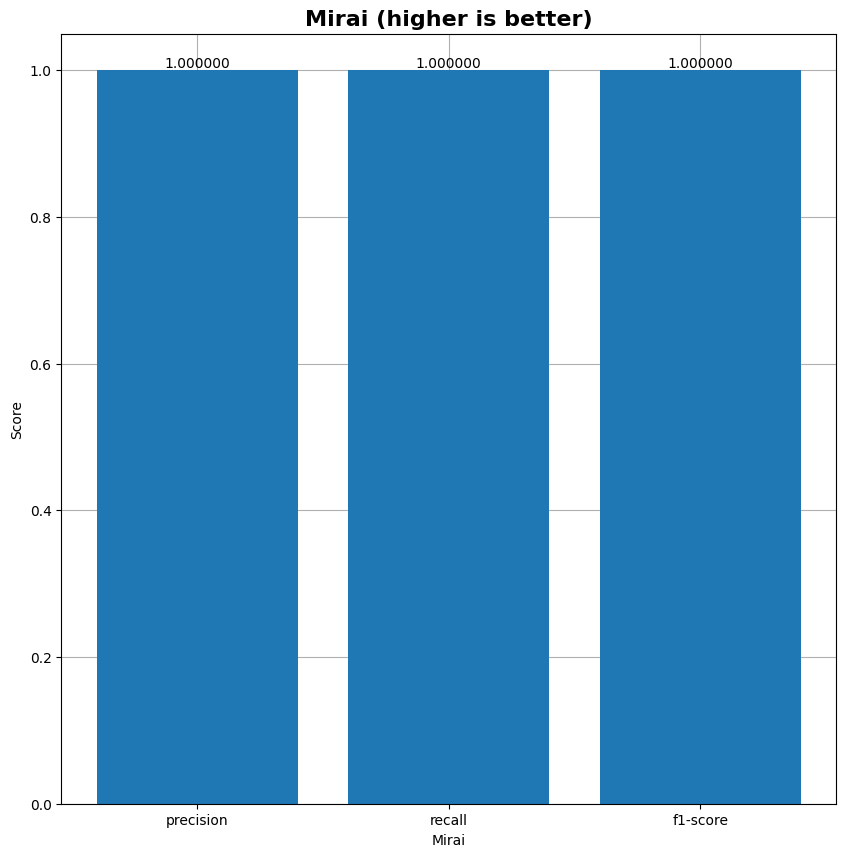

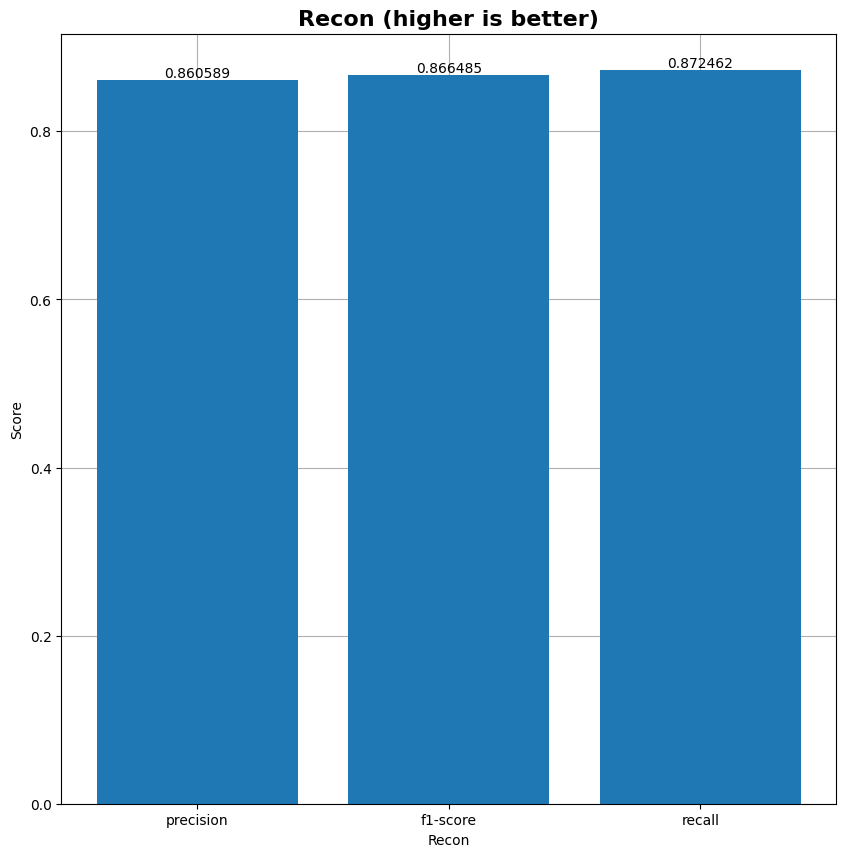

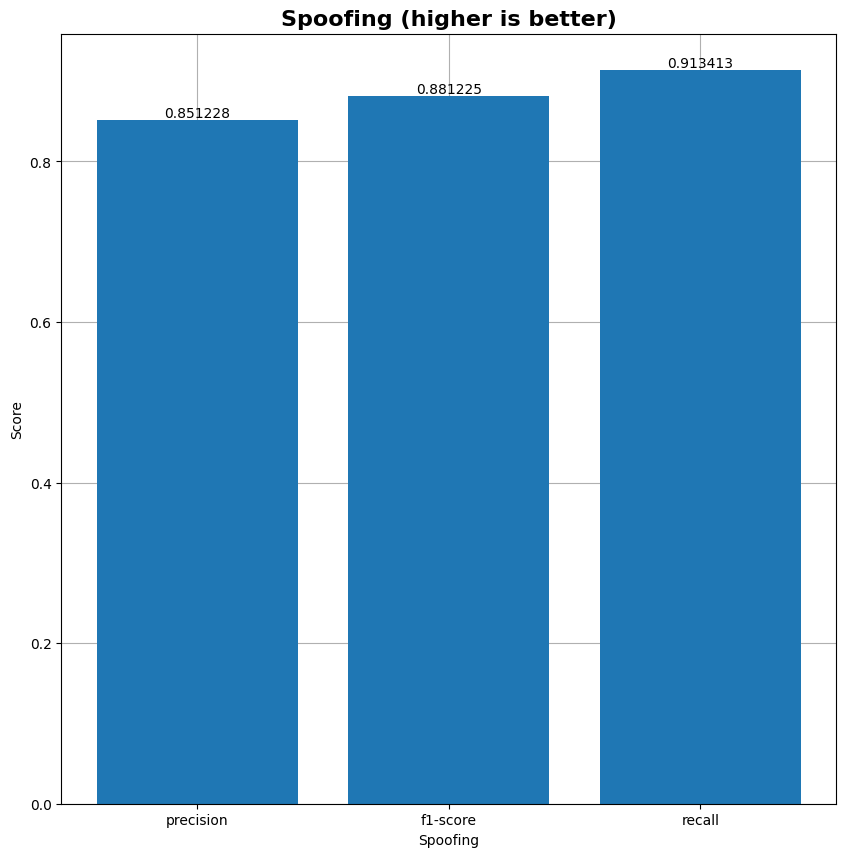

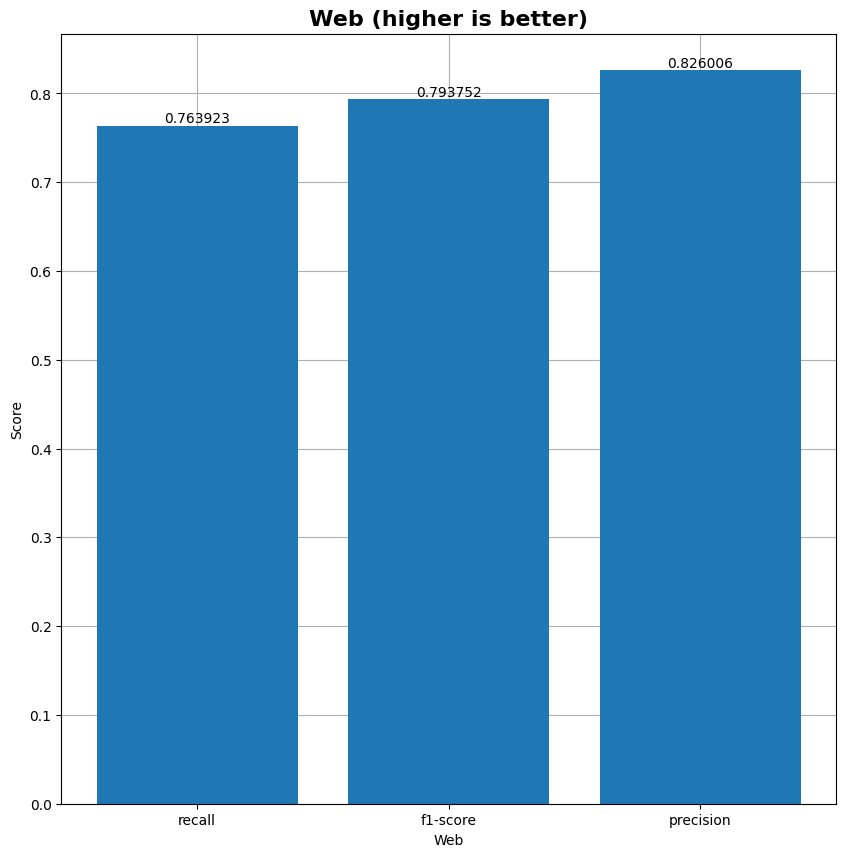

In [46]:
plot_mc(y_pred, y_test, "LightGBM")

In [47]:
model_name = "LightGBM_60000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((277331, 46), (277331,), (60878, 46), (60878,), (59684, 46), (59684,))

In [16]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744742073.912058  194562 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4904 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744742076.601409  195031 service.cc:152] XLA service 0x7122b4005100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744742076.601437  195031 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-15 21:34:36.624961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744742076.779882  195031 cuda_dnn.cc:529] Loaded cuDNN version 90300


   73/17334 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.4635 - loss: 1.4671   

I0000 00:00:1744742077.594268  195031 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17334/17334 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.7091 - loss: 0.6830 - val_accuracy: 0.7522 - val_loss: 0.5775
Epoch 2/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.7566 - loss: 0.5634 - val_accuracy: 0.7599 - val_loss: 0.5529
Epoch 3/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.7683 - loss: 0.5425 - val_accuracy: 0.7638 - val_loss: 0.5484
Epoch 4/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.7736 - loss: 0.5303 - val_accuracy: 0.7742 - val_loss: 0.5279
Epoch 5/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.7763 - loss: 0.5207 - val_accuracy: 0.7695 - val_loss: 0.5377
Epoch 6/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.7785 - loss: 0.5259 - val_accuracy: 0.7756 - val_loss: 0.5301
Epoch 7/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.7789 - loss: 0.5155 - val_accuracy: 0.7689 - val_loss: 0.5295
Epoch 8/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.7803 - lo

In [19]:
y_pred = np.argmax(y_pred, axis=1)

In [20]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

1866/1866 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7803 - loss: 3.6054


In [21]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [22]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [23]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
FF-NN,0.781332,0.787902,0.781733,0.781332,0.746144,0.63104,2.840879,1.685491,866.850097


{'precision': {'Benign': 0.7974128233970754, 'Bruteforce': 0.370004933399112, 'DDoS': 0.7540947321823815, 'DoS': 0.8510073057338942, 'Mirai': 0.99357198271085, 'Recon': 0.7217101610216546, 'Spoofing': 0.7097917589720868, 'Web': 0.6646525679758308}, 'recall': {'Benign': 0.7852237483385024, 'Bruteforce': 0.6142506142506142, 'DDoS': 0.8399901380670611, 'DoS': 0.7766441054651985, 'Mirai': 0.9971082193304416, 'Recon': 0.7157488986784141, 'Spoofing': 0.7788987480247964, 'Web': 0.4721030042918455}, 'f1-score': {'Benign': 0.7912713472485768, 'Bruteforce': 0.4618226600985222, 'DDoS': 0.794728248192209, 'DoS': 0.8121269740664449, 'Mirai': 0.9953369601421117, 'Recon': 0.7187171689245231, 'Spoofing': 0.7427412344248044, 'Web': 0.5520702634880803}}


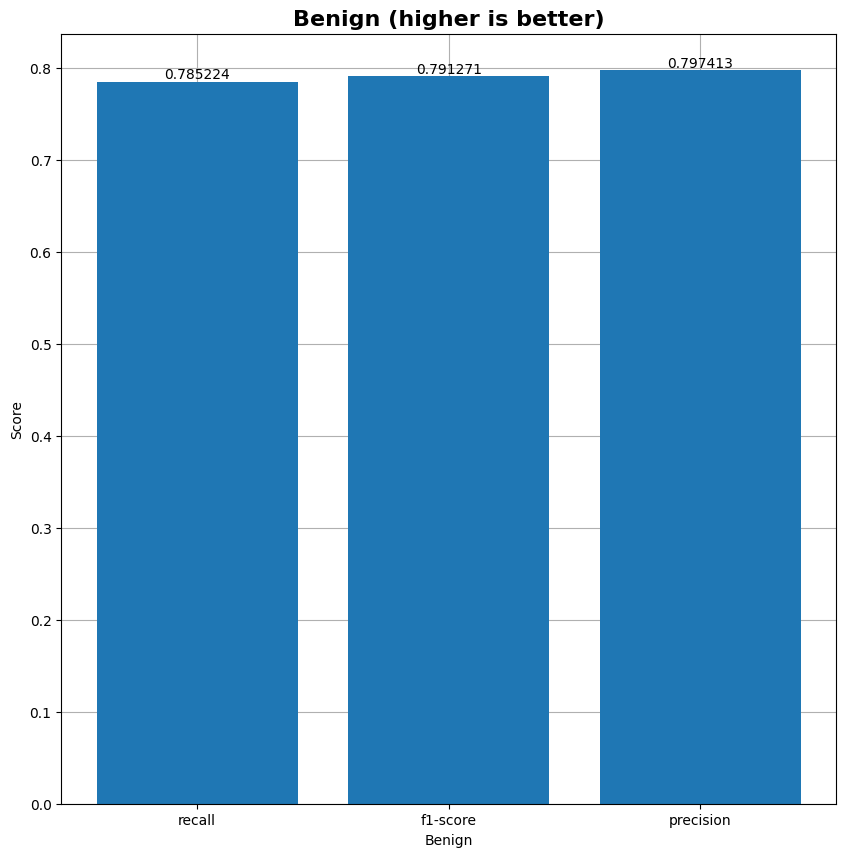

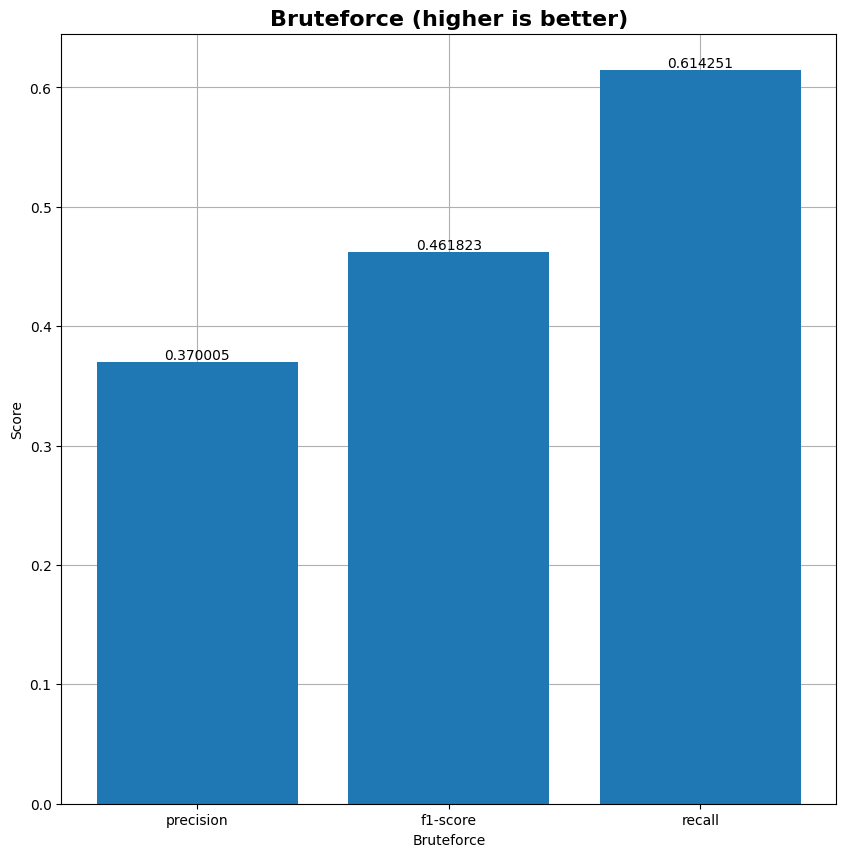

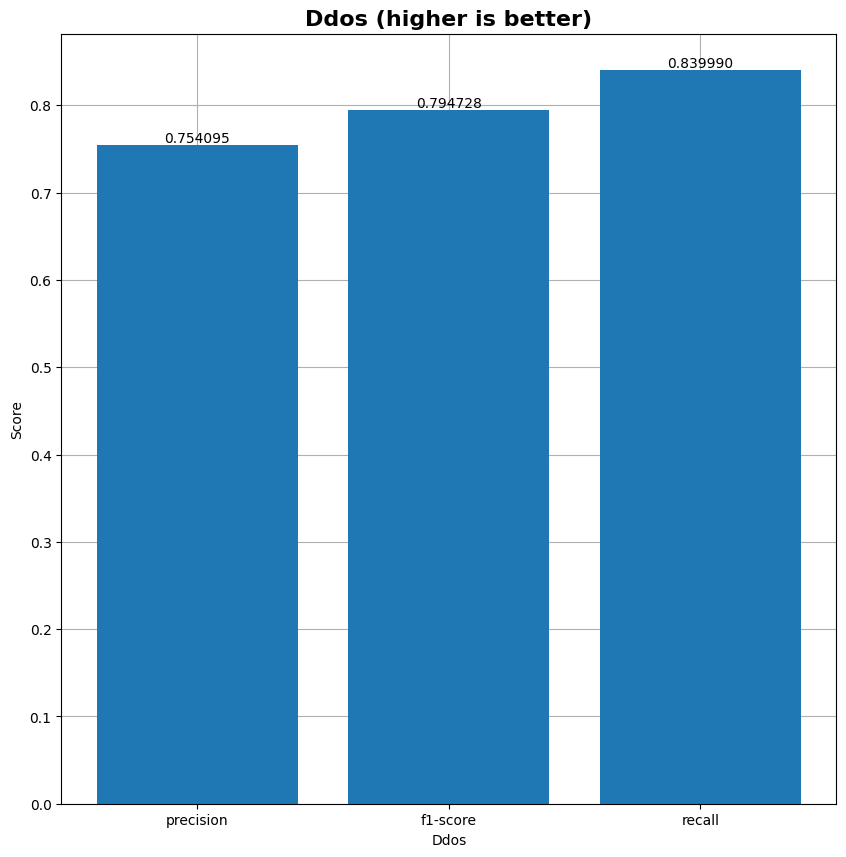

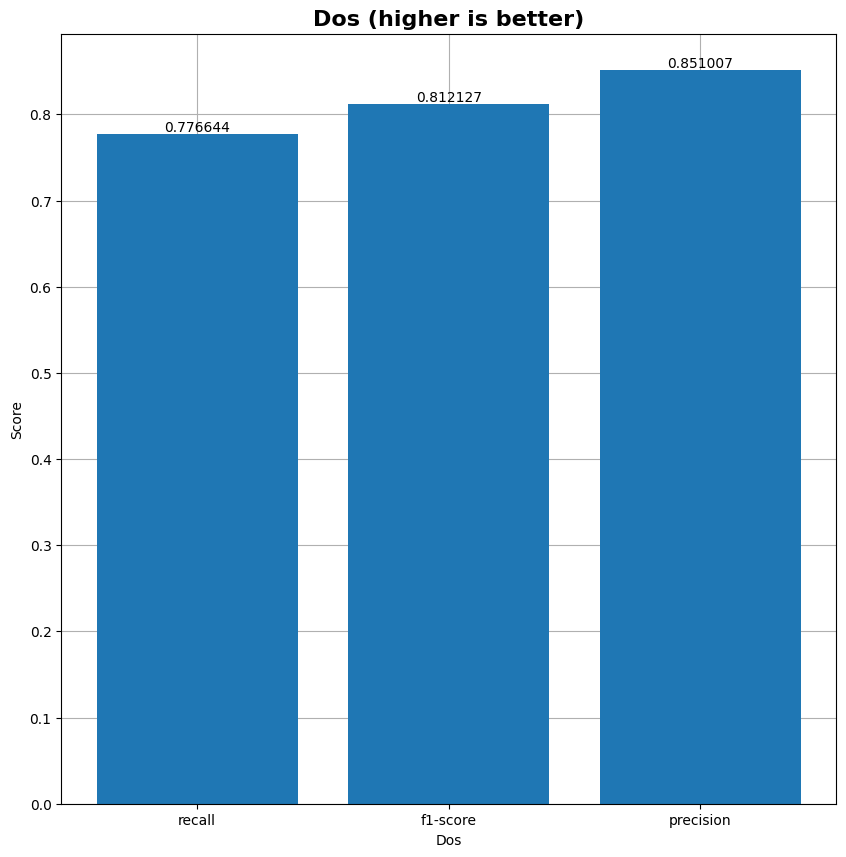

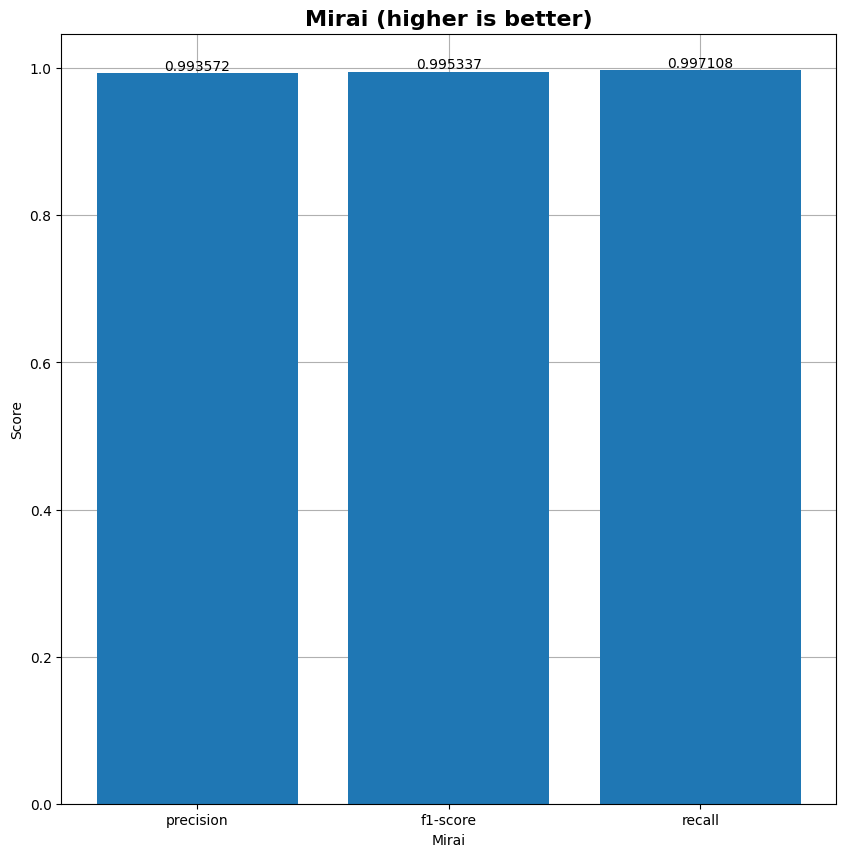

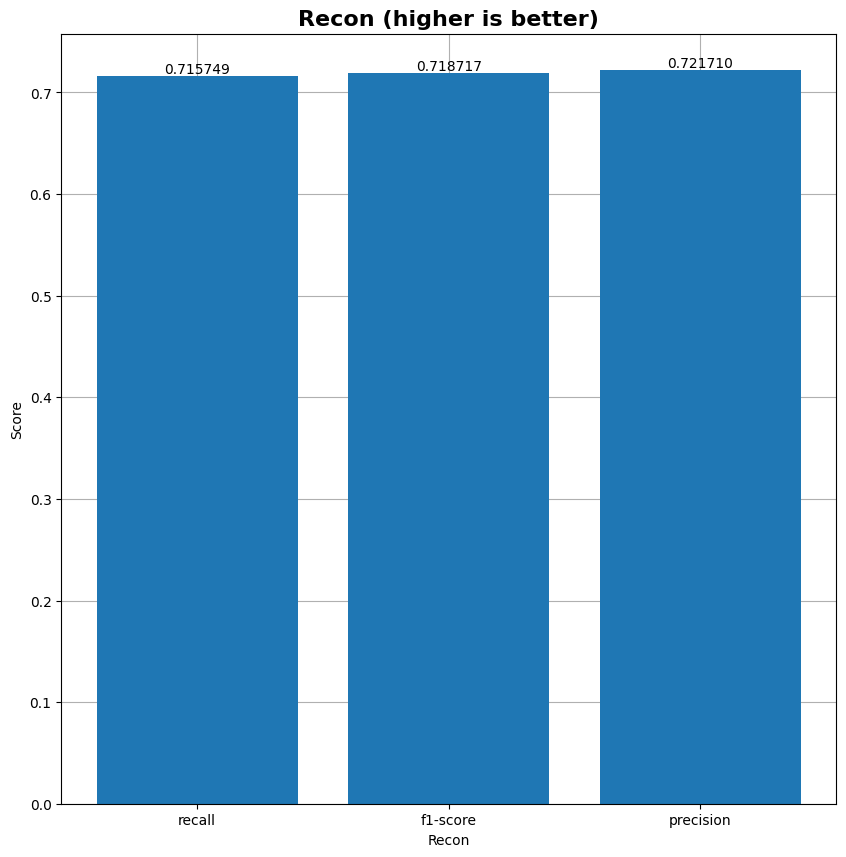

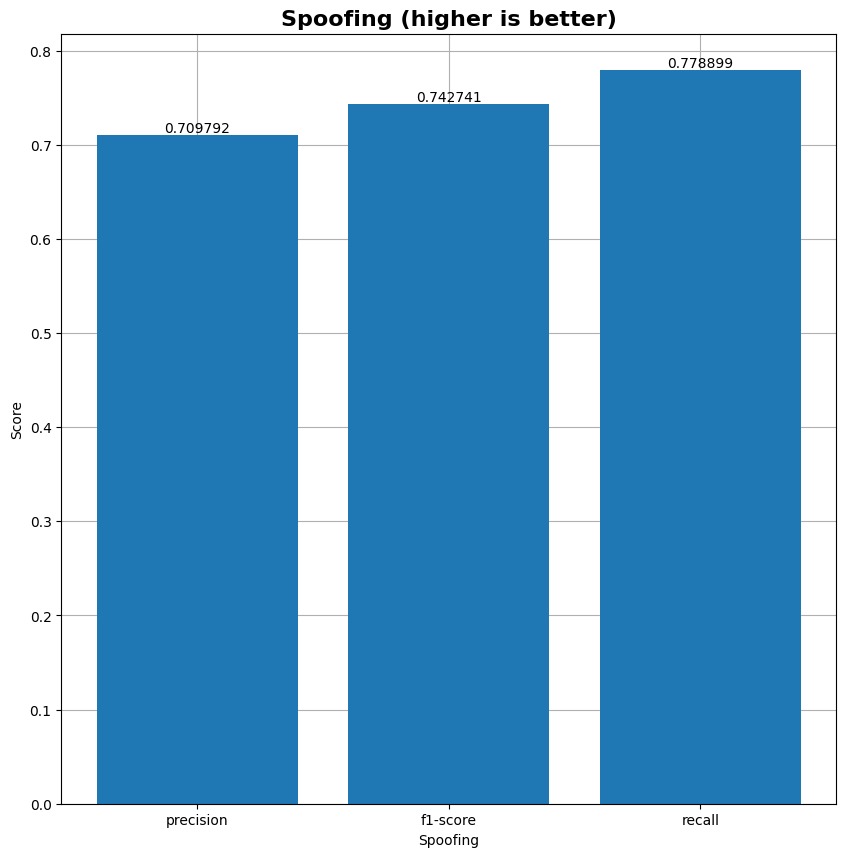

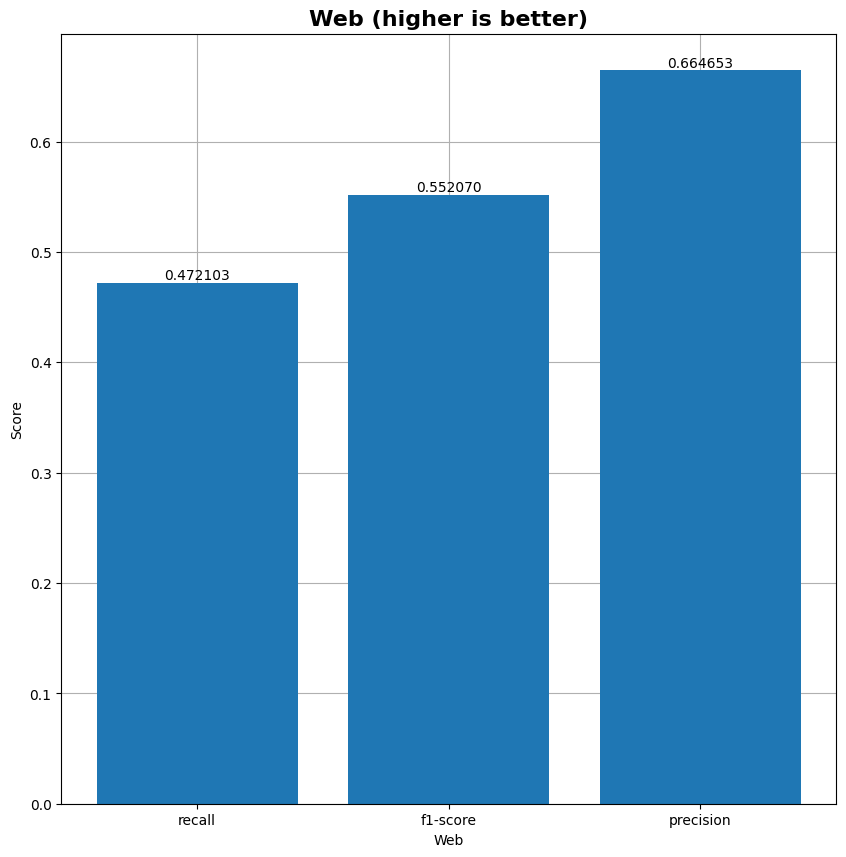

In [24]:
plot_mc(y_pred, y_test, "FF-NN")

In [25]:
model_name = "FFNN_60000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [26]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [27]:
num_components = len(np.unique(y))

In [28]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [29]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [31]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - accuracy: 0.9829 - loss: 0.0710 - val_accuracy: 0.9991 - val_loss: 0.0040
Epoch 2/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 3/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 4/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9998 - val_loss: 9.8537e-04
Epoch 5/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9999 - val_loss: 4.1403e-04
Epoch 6/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - accuracy: 0.9998 - loss: 7.8015e-04 - val_accuracy: 0.9999 - val_loss: 7.4207e-04
Epoch 7/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 70s 8ms/step - accuracy: 0.9999 - loss: 5.1497e-04 - val_accuracy: 0.9999 - val_loss: 4.3089e-04
Epoch 8/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 69s 8ms/step - ac

In [34]:
_, accuracy = model.evaluate(X_test, y_test)

1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9999 - loss: 4.3738e-04


In [35]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [36]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [37]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [38]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [39]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
FF-NN,0.781332,0.787902,0.781733,0.781332,0.746144,0.631040,2.840879,1.685491,866.850097
LSTM,0.999899,0.999900,0.999899,0.999899,0.999883,0.000218,0.000788,0.028063,703.218452


{'precision': {'Benign': 1.0, 'Bruteforce': 0.9994962216624685, 'DDoS': 0.9997750281214848, 'DoS': 1.0, 'Mirai': 1.0, 'Recon': 0.9996639784946236, 'Spoofing': 1.0, 'Web': 1.0}, 'recall': {'Benign': 1.0, 'Bruteforce': 1.0, 'DDoS': 1.0, 'DoS': 0.9997787365859055, 'Mirai': 1.0, 'Recon': 1.0, 'Spoofing': 0.9998881306633851, 'Web': 0.9992209815632304}, 'f1-score': {'Benign': 1.0, 'Bruteforce': 0.999748047367095, 'DDoS': 0.9998875014062324, 'DoS': 0.999889356052224, 'Mirai': 1.0, 'Recon': 0.9998319610149554, 'Spoofing': 0.9999440622028305, 'Web': 0.9996103390050656}}


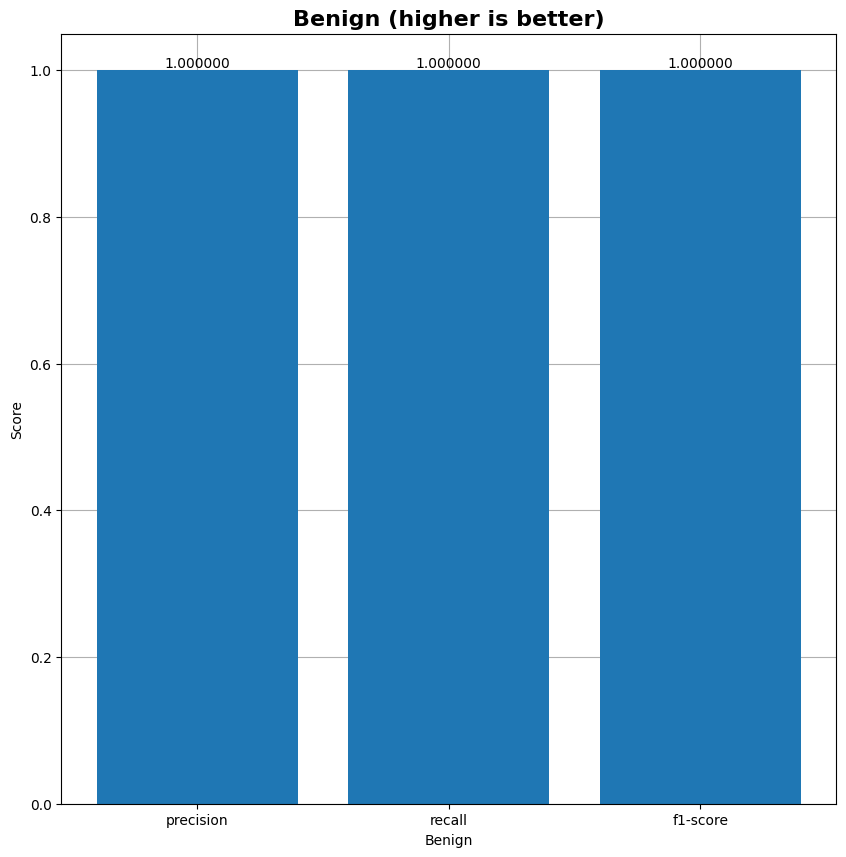

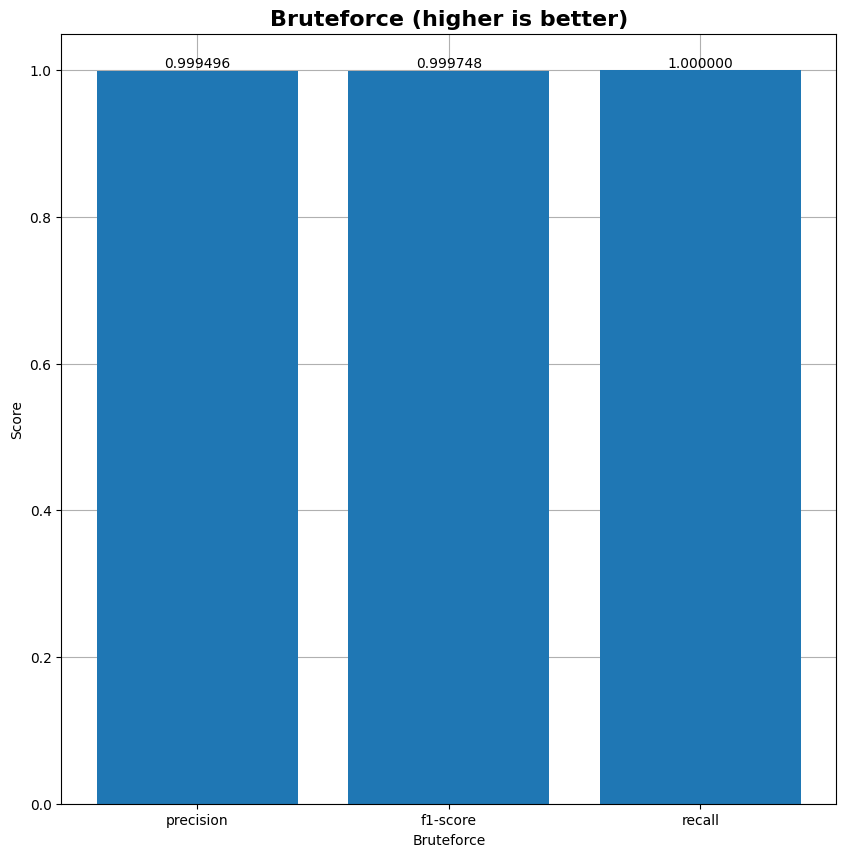

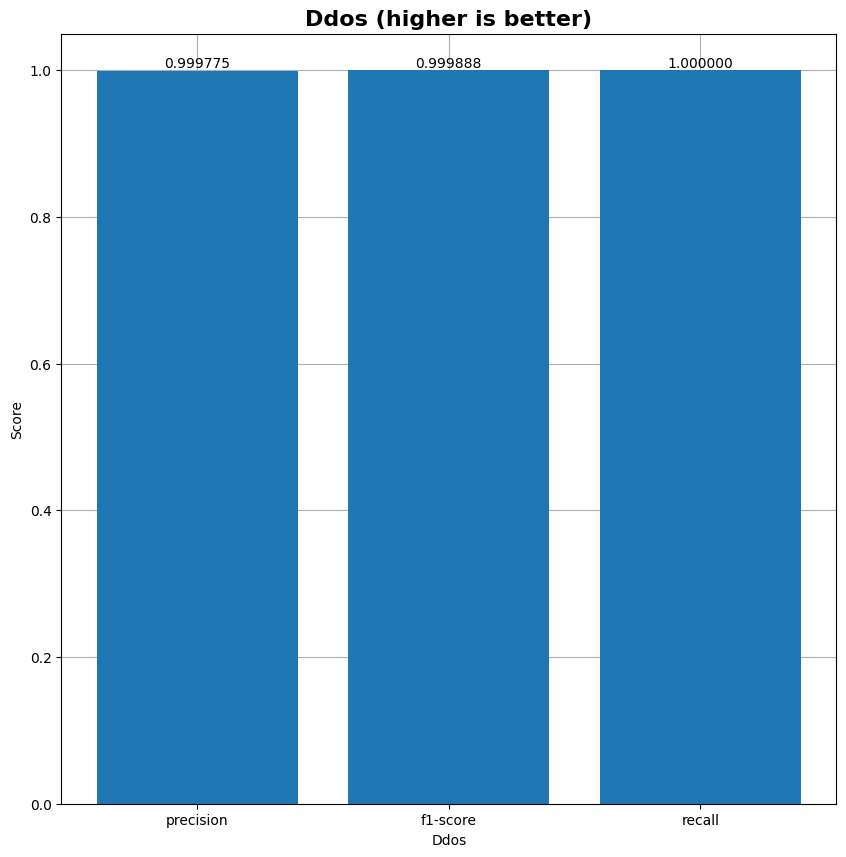

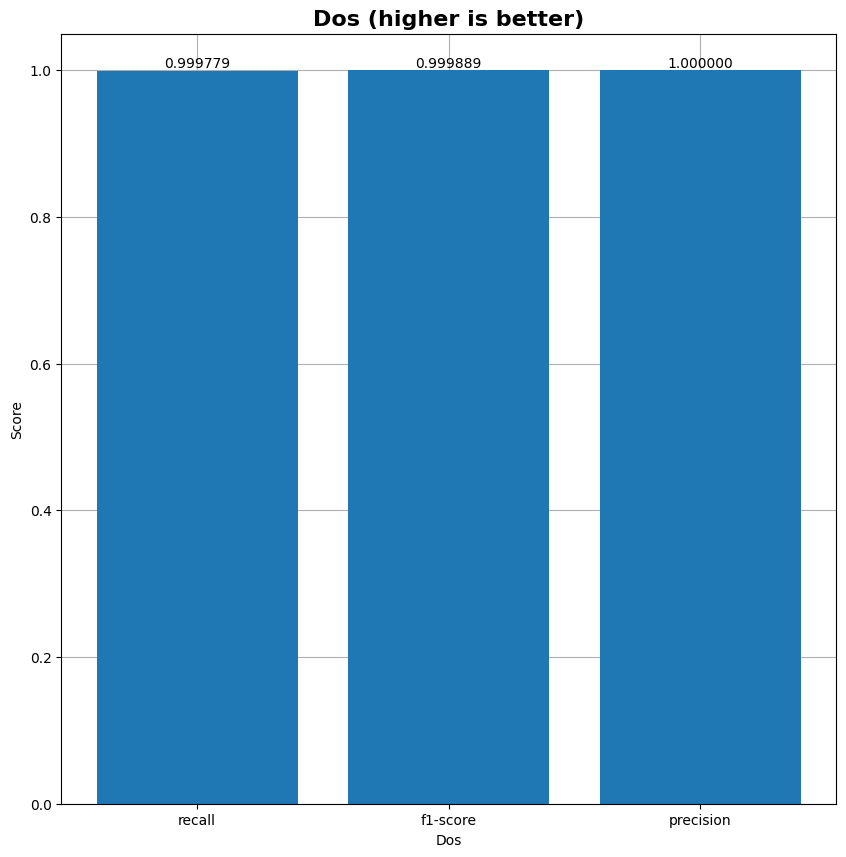

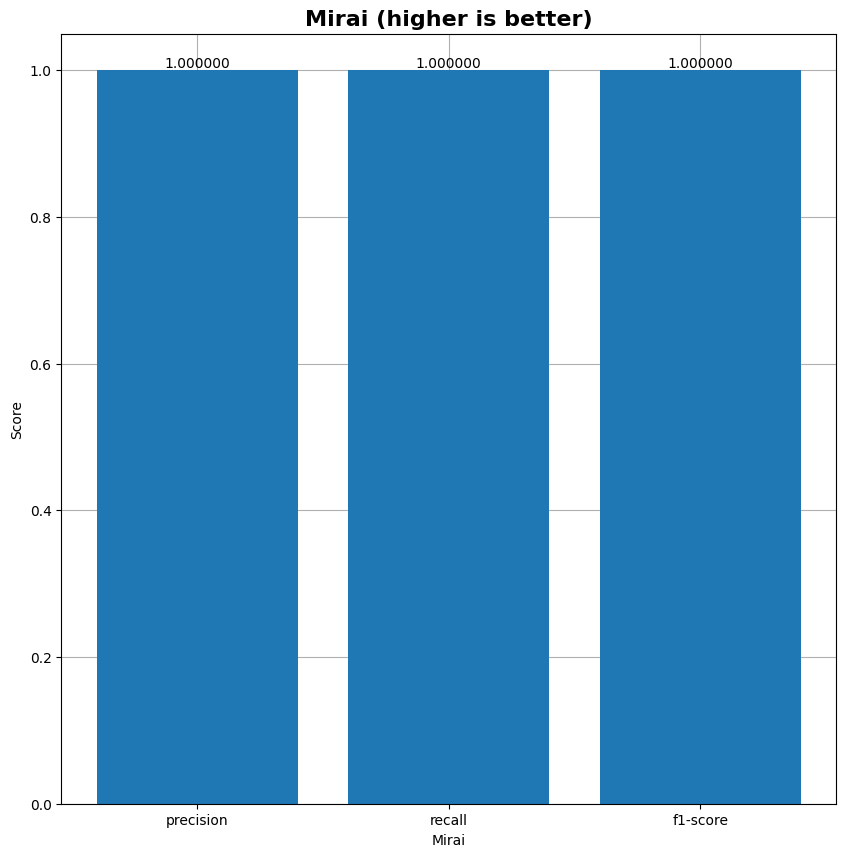

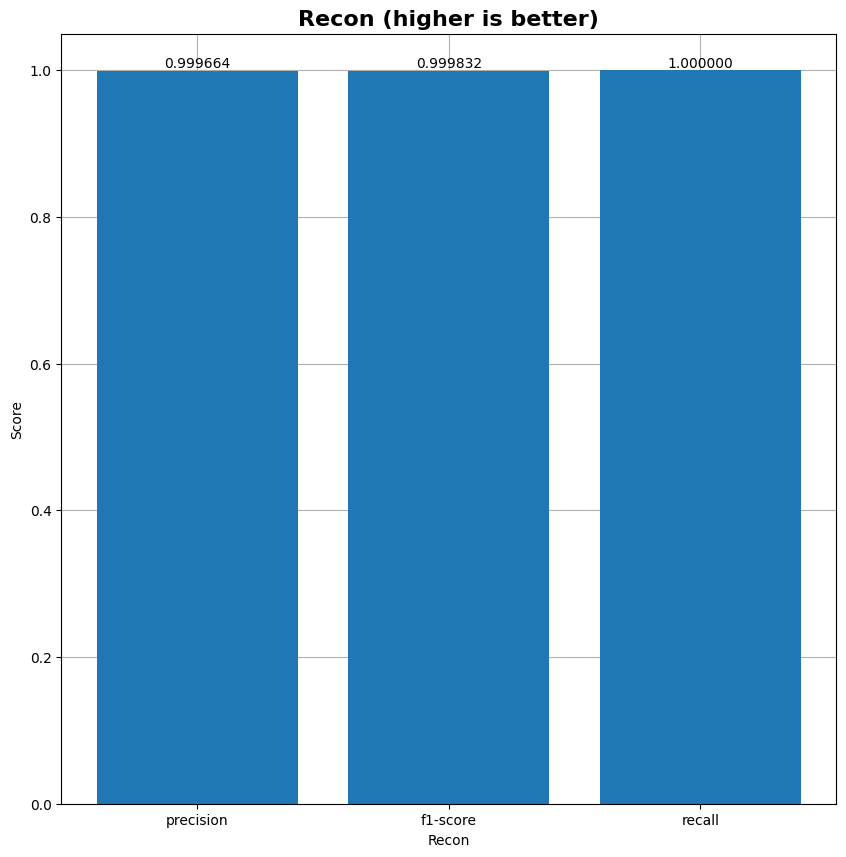

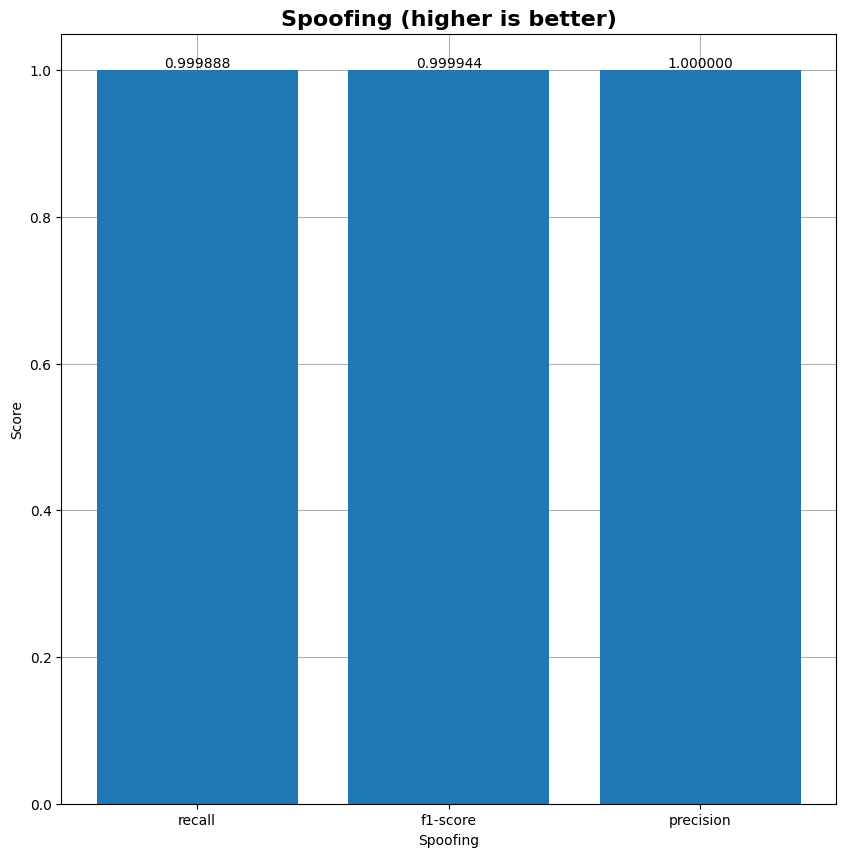

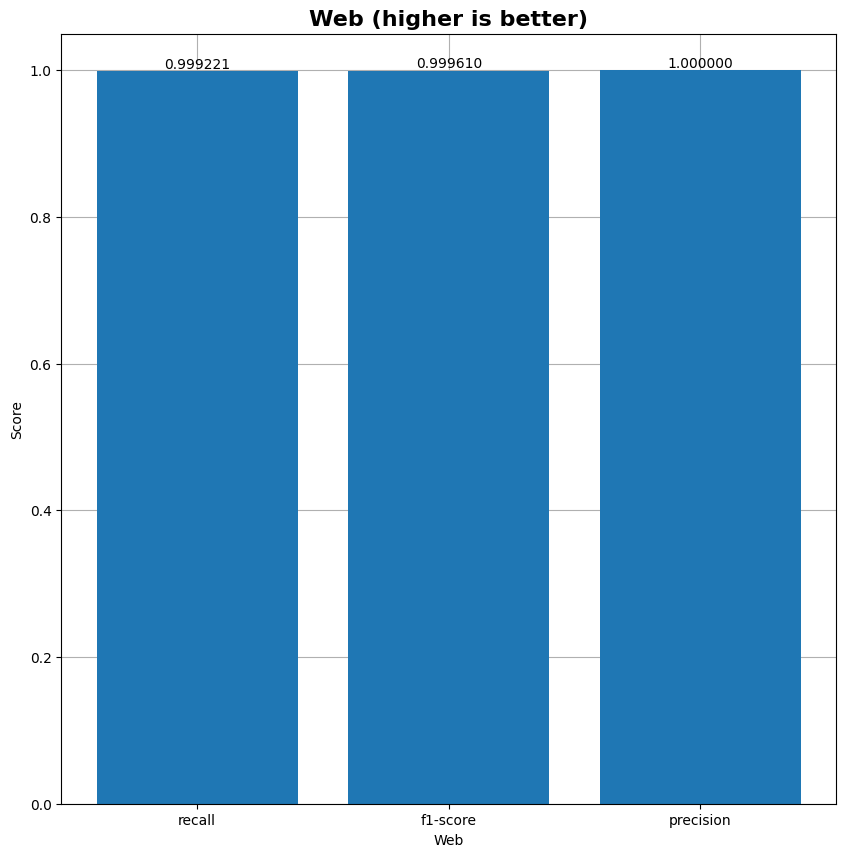

In [40]:
plot_mc(y_pred, y_test, "LSTM")

In [41]:
model_name = "LSTM_60000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

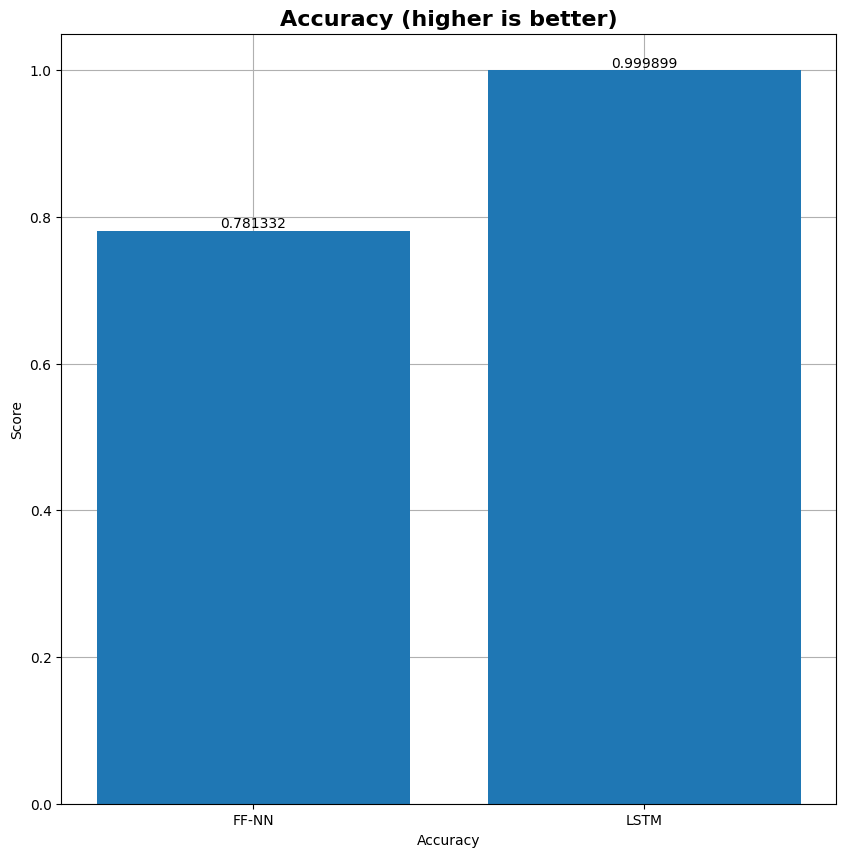

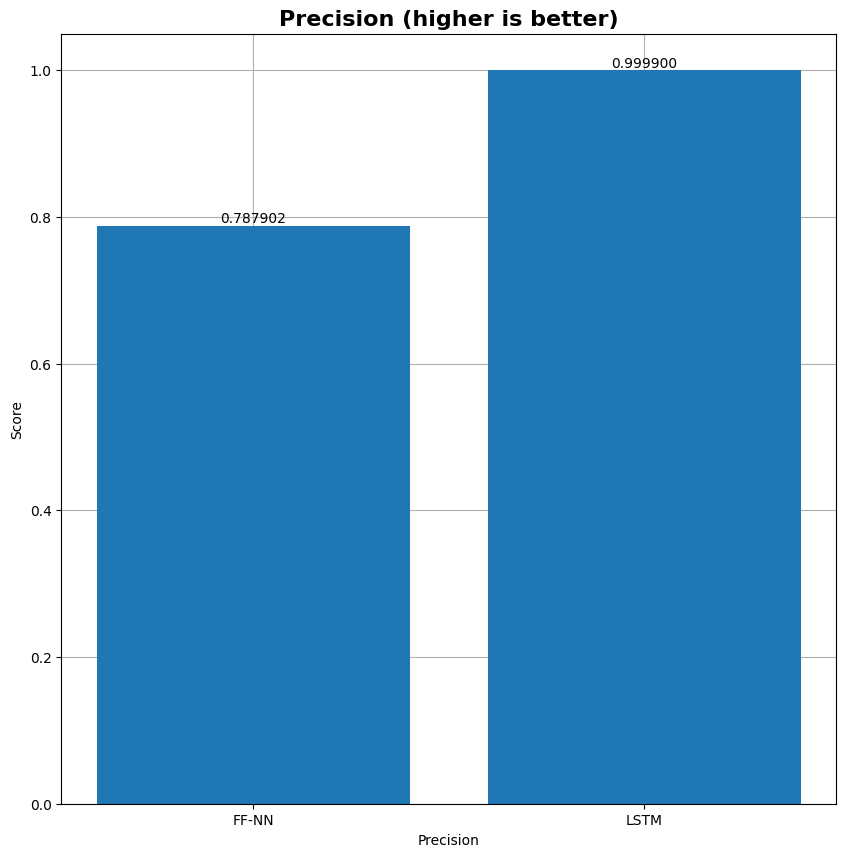

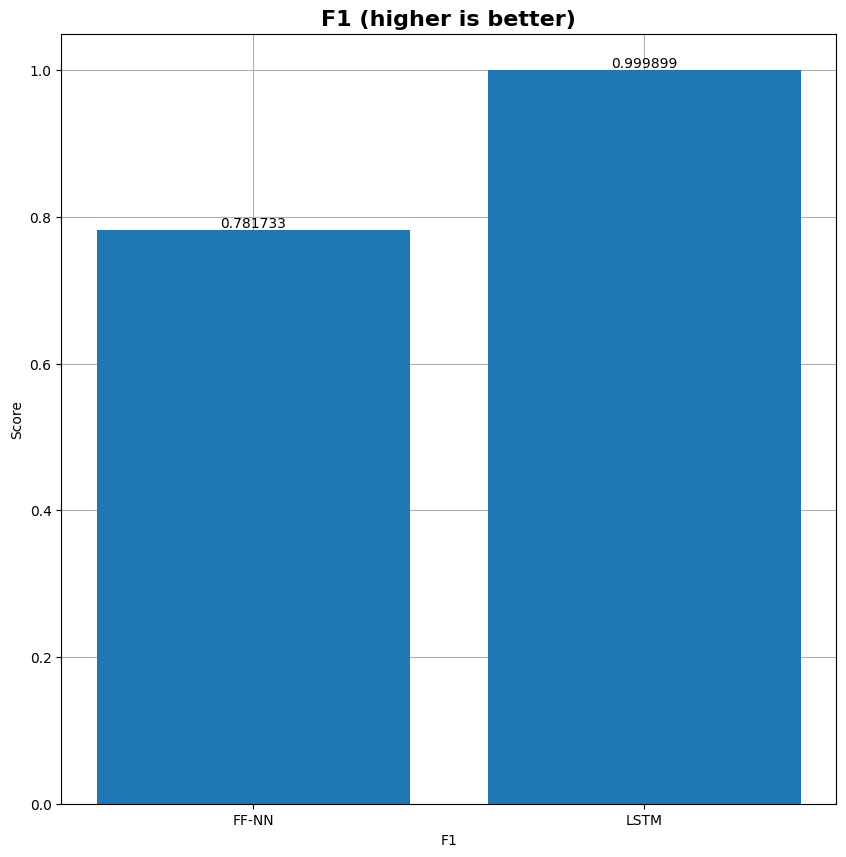

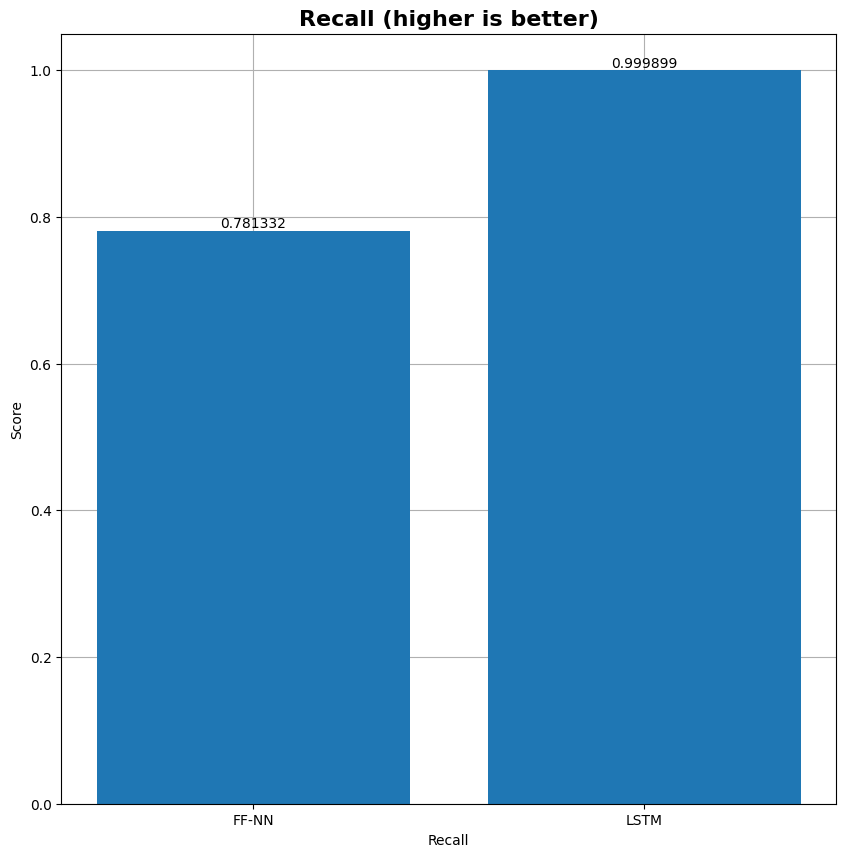

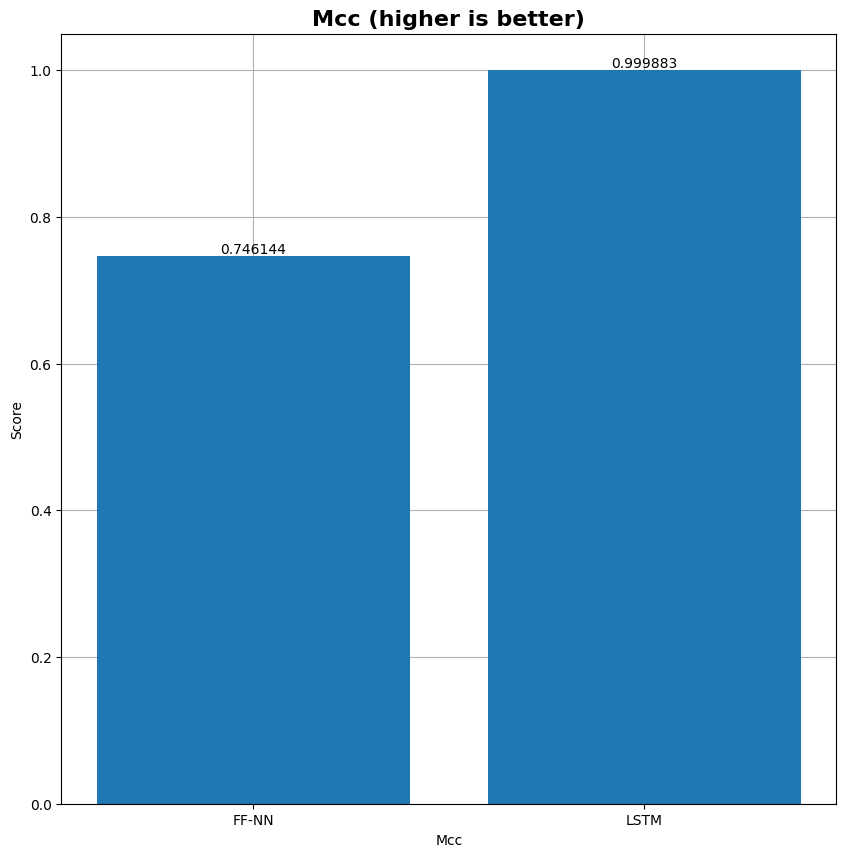

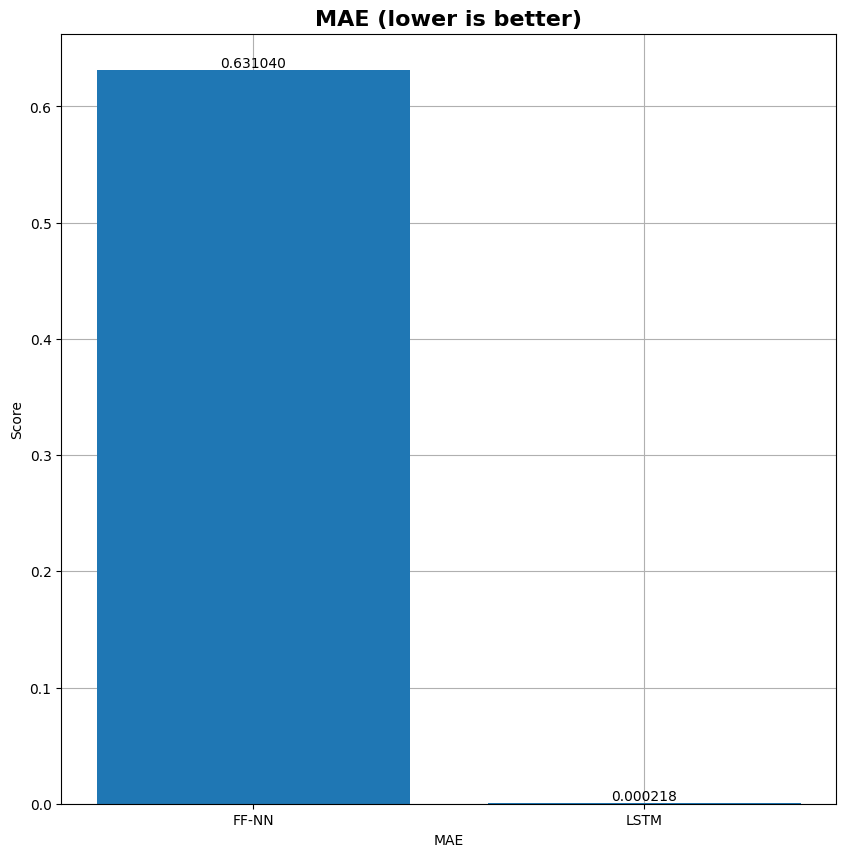

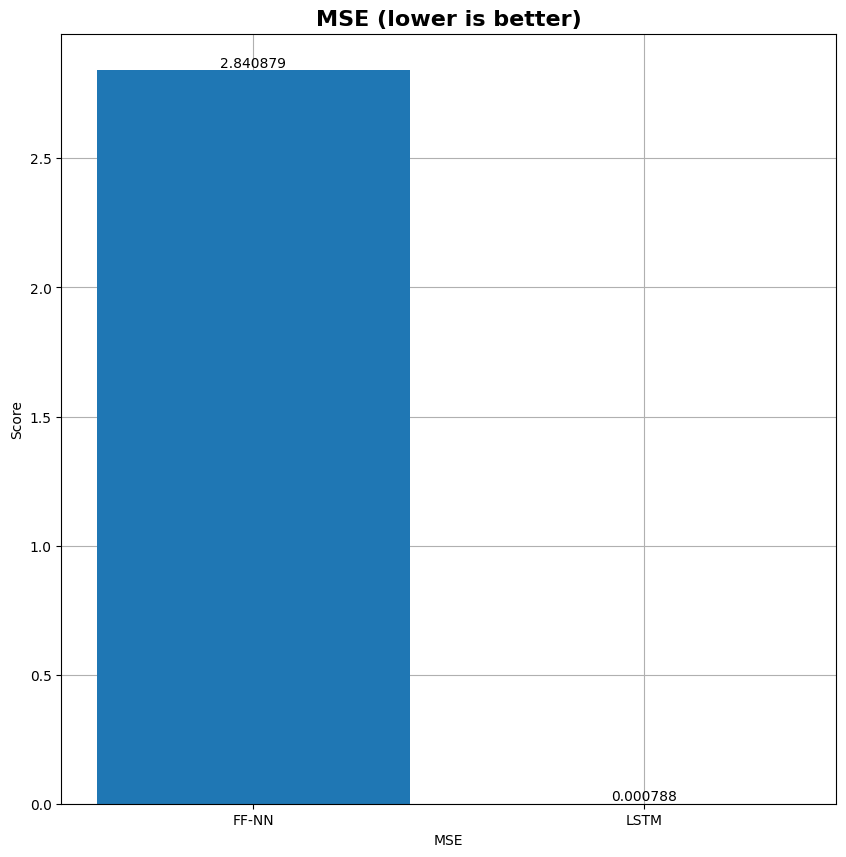

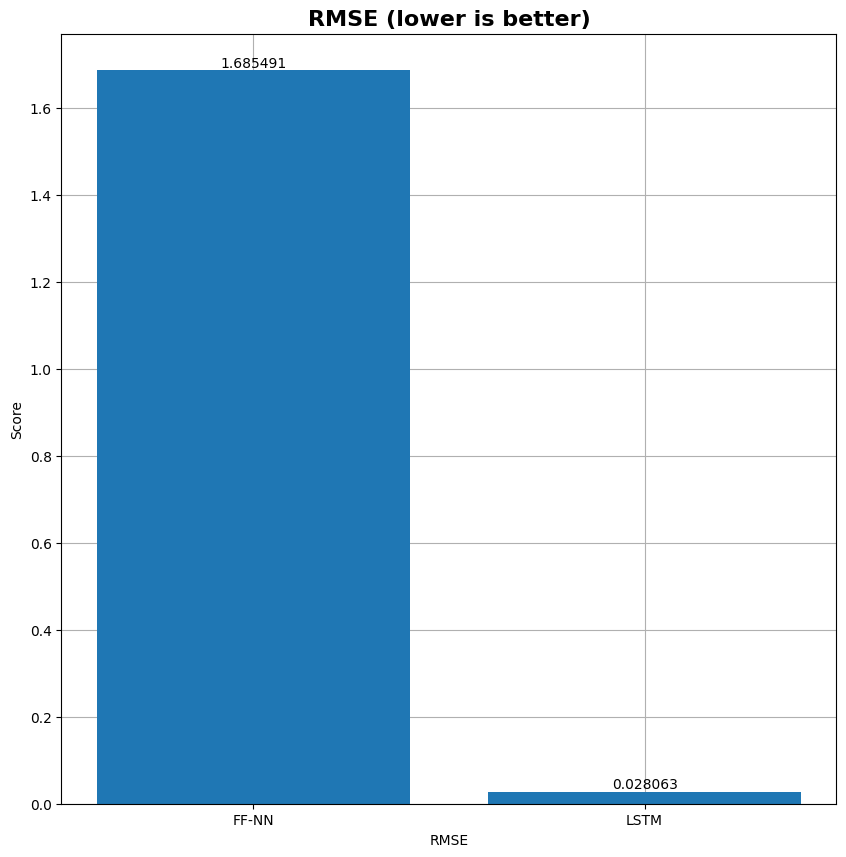

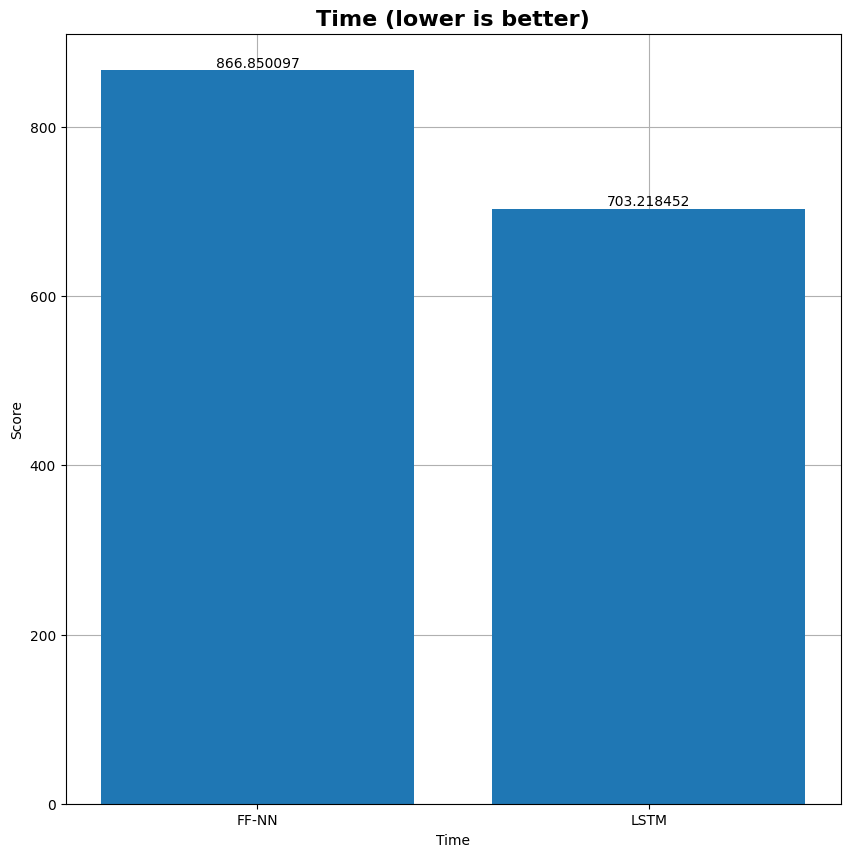

In [42]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [43]:
df_dict = results_df.to_dict()

In [44]:
values = ['Precision', 'Recall', 'F1']
new_dict = {}
for value in values:
    new_dict[value] = df_dict[value]

In [45]:
new_dict

{'Precision': {'FF-NN': 0.7879017841561224, 'LSTM': 0.999899513939972},
 'Recall': {'FF-NN': 0.7813316801822934, 'LSTM': 0.99989946549153},
 'F1': {'FF-NN': 0.7817332205401022, 'LSTM': 0.999899469388431}}

In [46]:
pd.DataFrame(new_dict).transpose()

,FF-NN,LSTM
Precision,0.787902,0.999900
Recall,0.781332,0.999899
F1,0.781733,0.999899
